In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import regex as reg
%matplotlib inline

Loading the data about universities:

In [2]:
universities = pd.read_pickle('data/Universities.pkl')
universities.head()

file                               name        domain  \
0  import2018_371  University of Colorado at Boulder  colorado.edu   
1  import2018_371  University of Colorado at Boulder  colorado.edu   
2  import2018_371  University of Colorado at Boulder  colorado.edu   
3  import2018_417  Indiana University at Bloomington   indiana.edu   
4  import2018_417  Indiana University at Bloomington     gmail.com   

                             email  author_order        country        Lat  \
0     rebecca.swanson@colorado.edu             0  United States  40.006667   
1  leighanna.hinojosa@colorado.edu             1  United States  40.006667   
2       joseph.polman@colorado.edu             2  United States  40.006667   
3             huang220@indiana.edu             0  United States  39.167222   
4              agomoll90@gmail.com             1  United States  39.167222   

          Lon  
0 -105.267222  
1 -105.267222  
2 -105.267222  
3  -86.521389  
4  -86.521389

In [3]:
universities.rename(columns={'email': 'mail'}, inplace=True)

## Mapping the participants:


A first overview of the community is given by looking at where the participants are from. Note that where a participant is from is determined by the location of the institution the are associated with. 
The size of the dot is choose based on the number of participants affiliated with that location. Each dot is set to be transparent so that locations with a more opaque coloring indicate a dense cluster of institutions participating.

We see that the eastern coast of north america and western europe show large dense clusters of participants. Furthermore, finland, israel, australia and japan have a large community of participants.

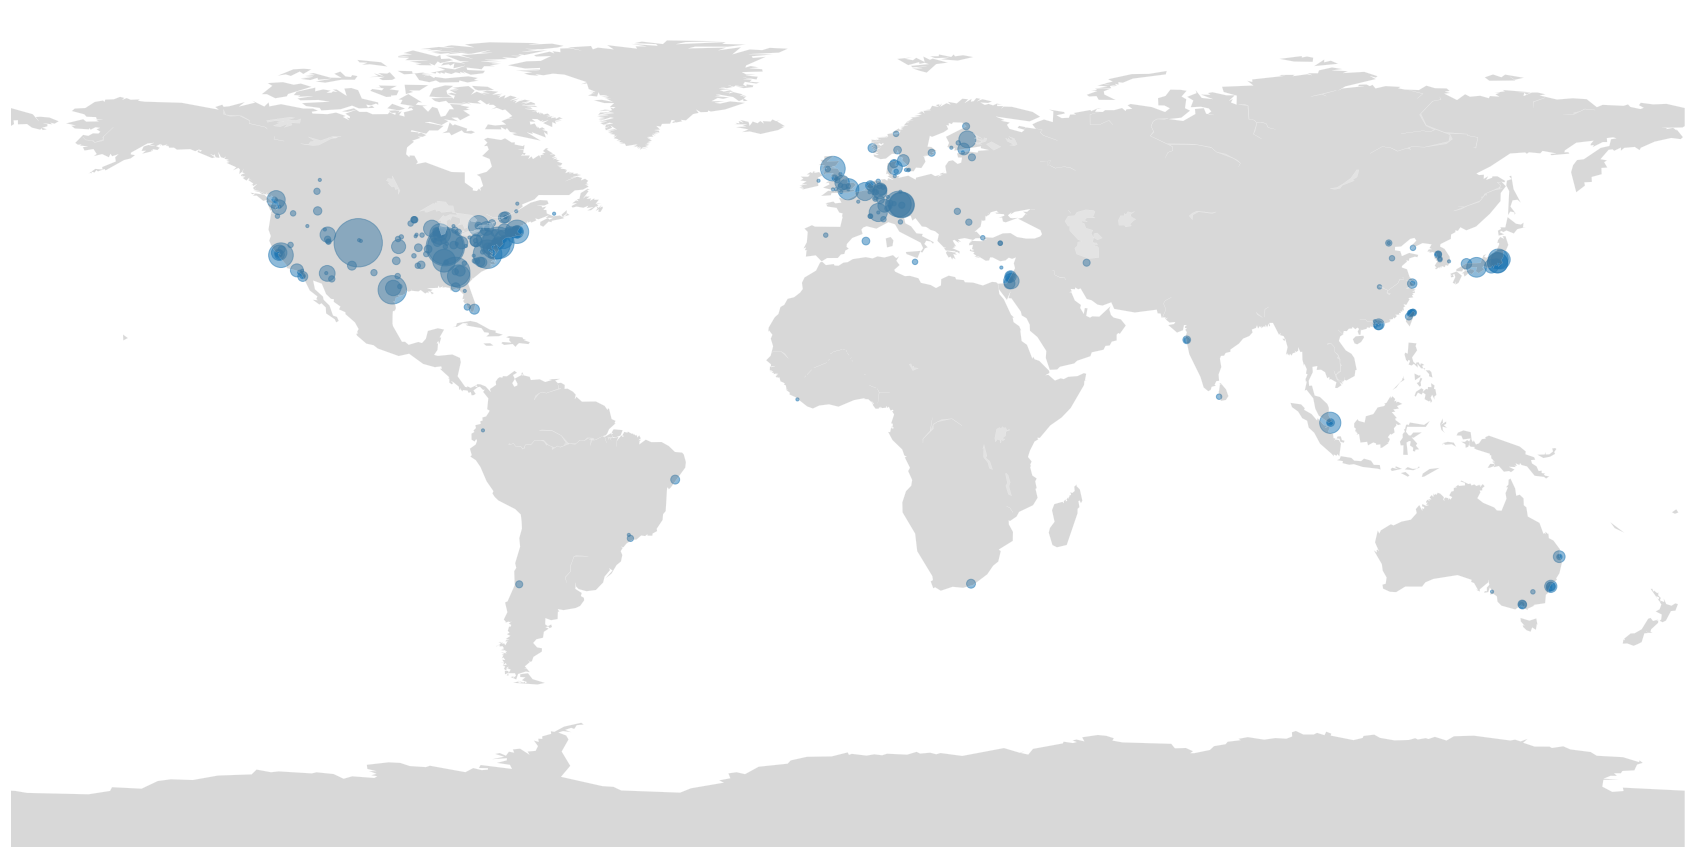

In [4]:
from mpl_toolkits.basemap import Basemap
#run export PROJ_LIB=$CONDA_PREFIX/share/proj if this gives a key error

plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
data = universities.drop_duplicates()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'], 
          s= universities.name.value_counts()*10, 
          alpha=.5)


## Base analysis of Universities present in dataset


Here we try to answer some basic questions regarding distribution of participants overall, how it varies by year, and look at ICLS and CSCL years

#### What universities has the most contributors, and what percentage do they make up:

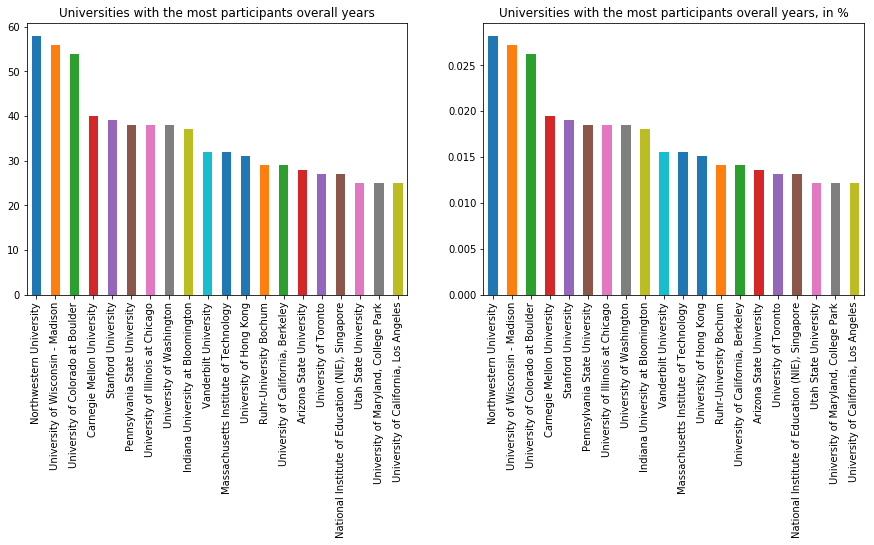

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Universities with the most participants overall years')
universities[(~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')

plt.subplot(122)
plt.title('Universities with the most participants overall years, in %')
(universities[(~universities.mail.duplicated())].name.value_counts().head(20)/universities[(~universities.mail.duplicated())].shape[0]).plot(kind='bar')
plt.show()

#### What are the countries where the most contributors are?

As determined by university affiliation

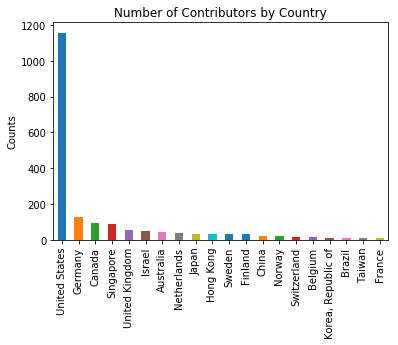

In [6]:
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')
plt.show()

## Considering ICLS and CSCL:

We look at which universities are present every year, only present during CSCL years and ICLS years:

In [7]:
universities['merge_index'] = universities.apply(lambda x: x['file']+str(x['author_order']), axis=1)

metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])
metadata.issued = metadata.issued.map(lambda x: x.year)
metadata['merge_index'] = metadata.apply(lambda x: x['file']+str(x['author_order']), axis=1)
associations = pd.merge(universities, metadata, on='merge_index')

In [8]:
associations.rename(columns={'file_x': 'file'}, inplace=True)

Small note on the assumption made to avoide double counting participants: one person lists the same email in papers written by that person within the same year. This is not necessarily true for everybody, but currently we can not check based on name due to a variety of issues with the data (Naming order inconsistency, Naming inconsistency) 

In [9]:
#dataframe with paper - author - author affiliations
grouping =  associations.copy()
grouping = grouping[#only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) ]

In [10]:
#get universities by year
uni_year = grouping.groupby('issued').apply(lambda x: set(x['name']))

#get years in our dataset
years = uni_year.index.tolist()

#create a set of universities that have participated at some point
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

#now use odd and even years to determine universities that participated every year in either ICLS or CSCL

all_years = unis[0]
ICLS = all_
CSCL = all_
for i, x in enumerate(unis):
    all_years = all_years.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)

We now focus on universities that participated uniquely on one or the other conference:

In [11]:
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [12]:
print('Number of universities represeted every year: ', len(all_years))
print('Number of universities represeted at every ICLS but not CSCL: ', len(ICLS))
print('Number of universities represeted at every CSCL but not ICLS: ', len(CSCL))

Number of universities represeted every year:  37
Number of universities represeted at every ICLS but not CSCL:  55
Number of universities represeted at every CSCL but not ICLS:  9


We now look into publication counts per university over the years:

In [13]:
grouping =  associations.copy()
grouping = grouping[ #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.name.isin(all_years))]

ranks = pd.DataFrame(grouping.groupby('issued').name.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)
#look at how the dataframe is formated
ranks.head()

issued                               name  count
0    2015              University of Toronto     12
1    2015                Göteborg University      9
2    2015         Universität Duisburg-Essen      9
3    2015                EPFL - EPF Lausanne      8
4    2015  Indiana University at Bloomington      8

There seems to be some pattern indicating that even amongst universities that participate every year, there is a fluctuation of number of papers submitted by each university to ICLS and CSCL.

In [14]:
#we only look at universities that have at least two submissions  each year
all_ = set()
ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: all_.update(set(x['name'])))

for s in ranks[ranks['count'] > 2].groupby('issued').apply(lambda x: set(x['name'])).tolist():
    all_ = all_.intersection(s)

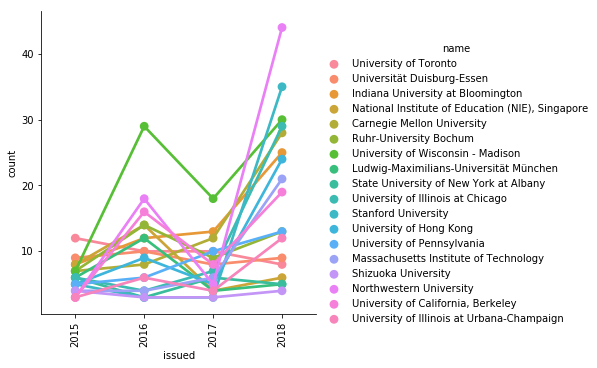

In [15]:
sns.catplot(data=ranks[ranks['name'].isin(all_) ], x='issued', y='count',kind='point', hue='name')
plt.xticks(rotation=90)
plt.show()

As 2018 saw an explosion of submissions overall, and is not a typical ICLS year, we do not further investigate this popularity difference between ICLS and CLCS for now.

### Plotting the difference on a map:

We put a dot whos size depends on the number of contributions on the map. blue: ICLS only inst.; orange: CSCL only inst.

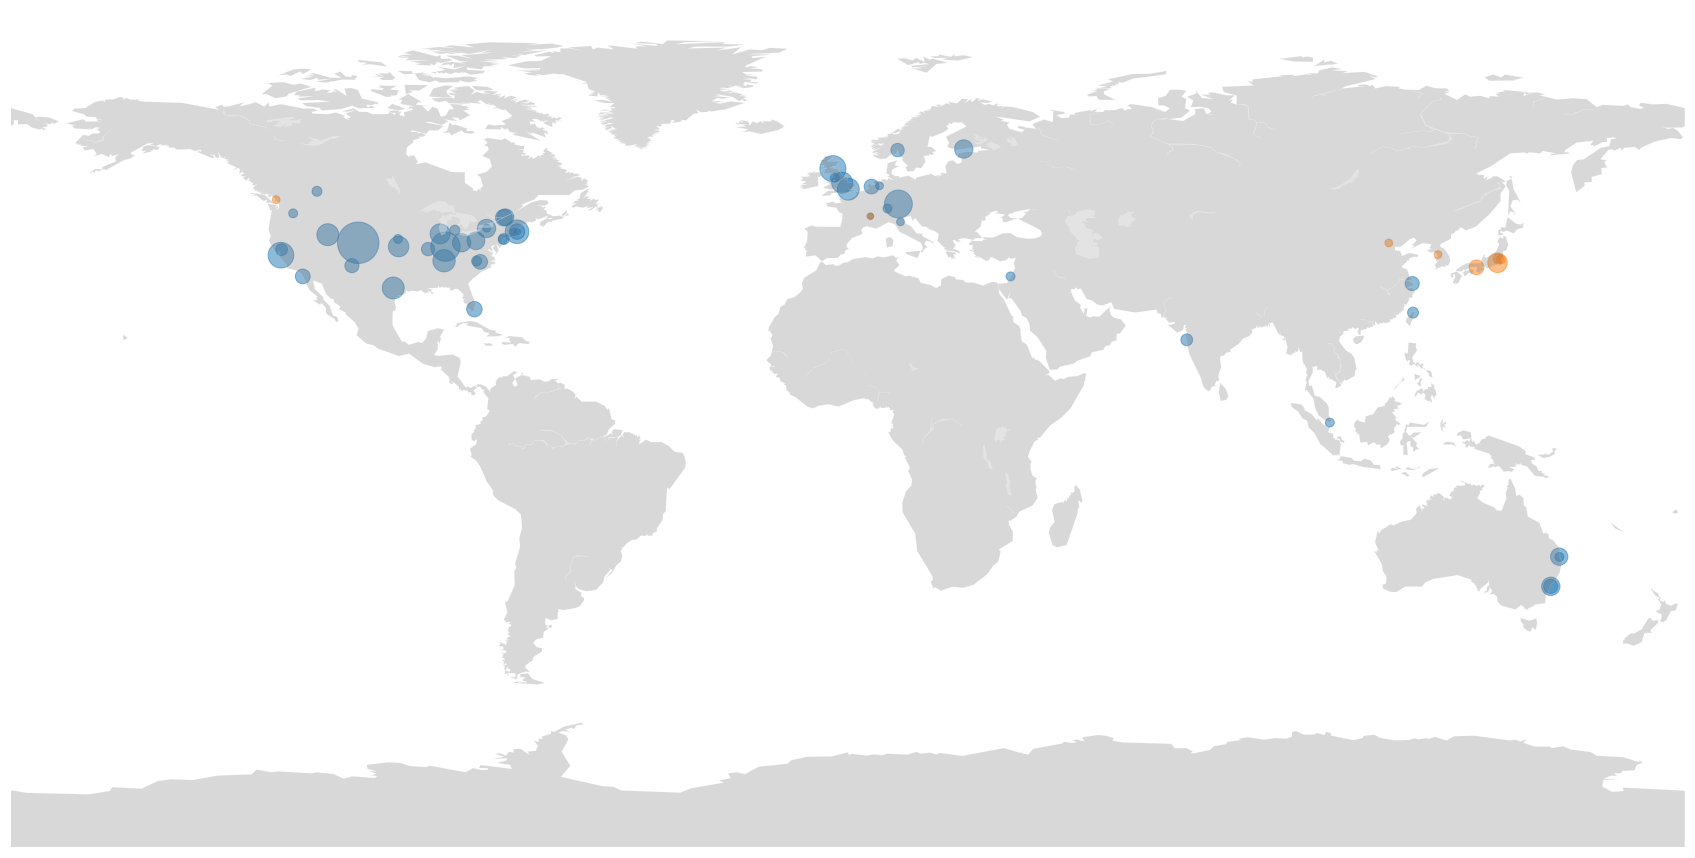

In [16]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = universities[universities.name.isin(ICLS)].copy()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'], 
          s=data.name.value_counts()*20, 
          cmap=plt.cm.Set2, alpha=0.5)

data = universities[universities.name.isin(CSCL)].copy()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'],
          s=data.name.value_counts()*20, 
          cmap=plt.cm.Set1, alpha=0.5)


The Orange dots are given by:

In [17]:
CSCL

{'Beijing Normal University',
 'Ecole Normale Supérieure de Lyon',
 'Educational Testing Service',
 'Hallym University',
 'Ibaraki University',
 'Kobe University',
 'Senshu University',
 'Simon Fraser University',
 'Utsunomiya University'}

## Universities participating every year:


We see that the universities participating every year form dense clusters of geographically close universities. 

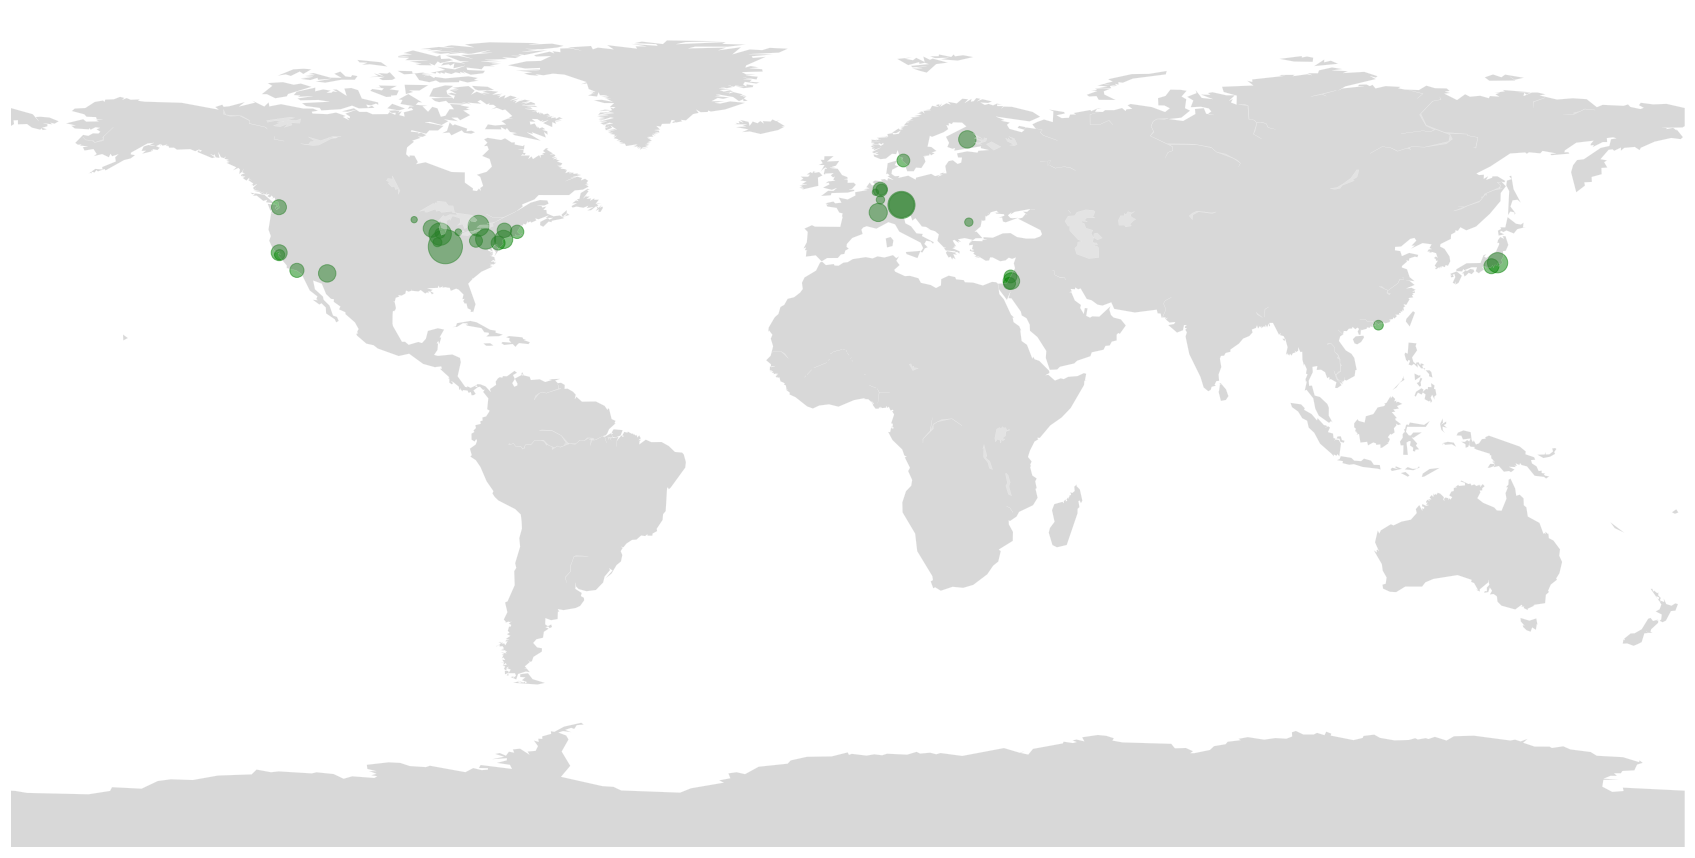

In [18]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

data = universities[universities.name.isin(all_years)].copy()
 
# Add a point per position
m.scatter(data[~data.name.duplicated()]['Lon'], 
          data[~data.name.duplicated()]['Lat'],
          s=data.name.value_counts()*5,
          c='green', alpha=0.5)

### Base analysis of Countries present in dataset:

We have an interessting result: **The increase in number of participants is mostly due to new participants from the U.S.A.**

In [19]:
uni_year = grouping.groupby('issued').apply(lambda x: set(x['country']))
years = uni_year.index.tolist()
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

all_years = unis[0]
ICLS = all_
CSCL = all_


for i, x in enumerate(unis):
    all_years = all_years.intersection(x)

In [20]:
grouping =  associations.copy()
grouping = grouping[
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated()) & 
                    #only consider universities that participated every year
                    (grouping.country.isin(all_years))]


ranks = pd.DataFrame(grouping.groupby('issued').country.value_counts())
ranks.columns = ['count']
ranks.reset_index(inplace=True)

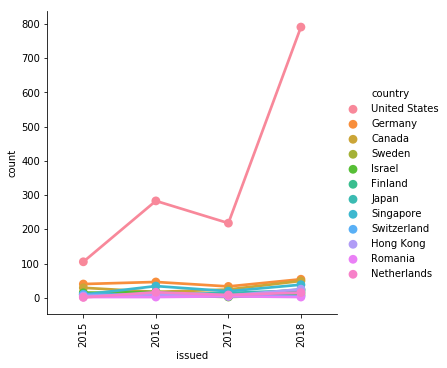

In [21]:
sns.catplot(data=ranks, x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

Looking at it without america:

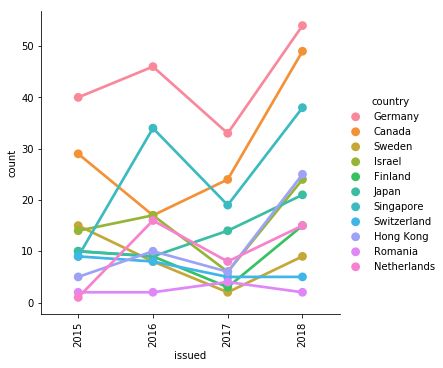

In [22]:
sns.catplot(data=ranks[(ranks.country != 'United States')], x='issued', y='count',kind='point', hue='country')
plt.xticks(rotation=90)
plt.show()

#### We now take an alternative view using stacked bar charts, to see evolution in percentage:

In [23]:
grouping =  associations.copy()
grouping = grouping[(grouping.name != 'gmail') & 
                    #only count a participant once (per year)
                    (~grouping[['issued', 'mail']].duplicated())]

In [24]:
viz = pd.DataFrame(grouping[['country', 'name', 'file', 'issued']].groupby(['issued', 'country']).name.value_counts())
viz.columns = ['counts']
viz.reset_index(inplace=True)

In [25]:
viz.head()

issued    country                     name  counts
0    2015  Australia     University of Sydney      11
1    2015     Canada    University of Toronto      12
2    2015     Canada  Simon Fraser University       6
3    2015     Canada           Dawson College       5
4    2015     Canada      John Abbott College       4

Set a colorbar to get more readable plot:

In [26]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()/viz.groupby(['issued']).counts.sum()*100).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
to_ignore = country_bar.loc[country_bar.counts < 1].country.unique()
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

country_bar.head()

country  issued     counts
0  Australia    2015   3.832753
1  Australia    2016   2.772277
2  Australia    2017   1.648352
3  Australia    2018   1.819757
4     Canada    2015  10.104530

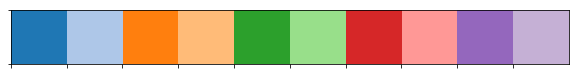

In [27]:
categories = country_bar.country.unique()
palette = sns.color_palette(palette='tab20', n_colors=len(categories)+1)

sns.palplot(palette)

We see that america makes up a bigger and bigger percentage

Text(0.5, 1.0, 'Participants by country (%)')

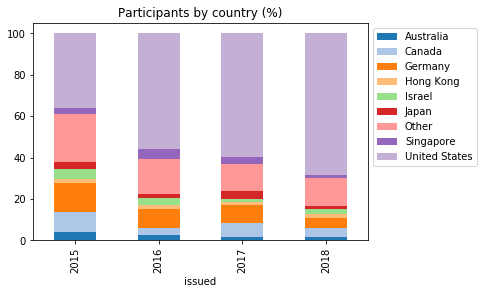

In [28]:
from matplotlib.colors import ListedColormap

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()

country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country (%)')

In terms of absolute attendance, countries with less than 4 participants in any year are grouped into other to improve visibility:

Text(0.5, 1.0, 'Participants by country by conference')

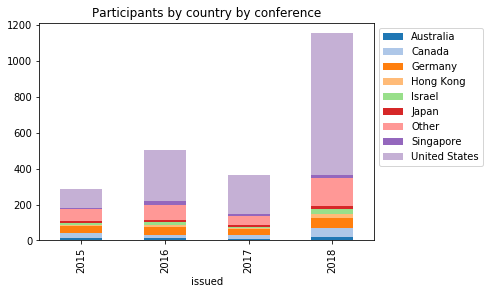

In [29]:
country_bar = pd.DataFrame(viz.groupby(['country', 'issued']).counts.sum()).copy()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)
country_bar.loc[country_bar.country.isin(to_ignore), 'country'] = 'Other'
country_bar = country_bar.groupby(['country', 'issued']).sum()
country_bar.columns = ['counts']
country_bar.reset_index(inplace=True)

categories = country_bar.country.unique()
palette = sns.color_palette(palette='tab20', n_colors=len(categories)+1)

country_bar = country_bar.pivot(index='issued', columns='country')
country_bar.columns = country_bar.columns.droplevel()
country_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Participants by country by conference')

#### Going back to looking at universities: why does the U.S have this increase in participation?

From before we know that some universities have very large increase in conference participation, therefore we look at the increase in the U.S.A. more closely. We see that there are a lot more of authors from various universities contributing, which weren't contributing before.

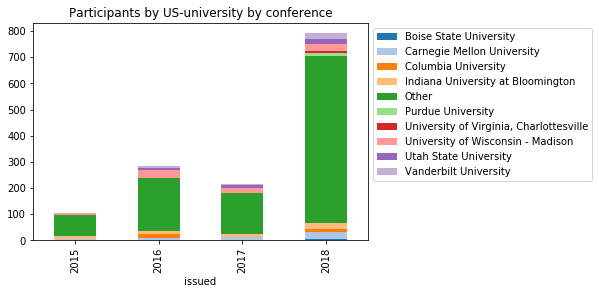

In [30]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

#universities to be grouped as other for better plotting
candidate = uni_bar.groupby('name').counts.min() > 5
to_ignore = candidate[candidate == False].index.tolist()


uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()

#set palette to have unique color for every label
palette = sns.color_palette(palette='tab20', n_colors=uni_bar.T.shape[0])

uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title('Participants by US-university by conference')

We look at the same graph with percentages, and see that the overall percentage of non major contributing institutions does not seem to change significantly over the years, hence the increase is not only due to new participants joining in !

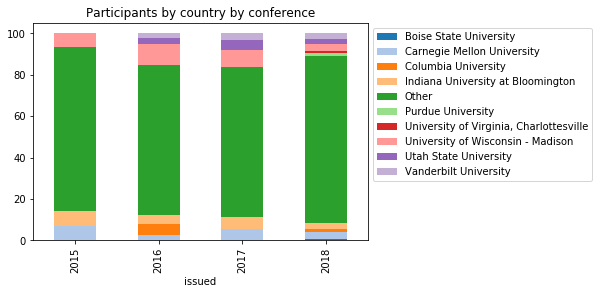

In [31]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()/uni_bar.groupby(['issued']).counts.sum()*100).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)
uni_bar.loc[uni_bar.name.isin(to_ignore), 'name'] = 'Other'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()
uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title('Participants by country by conference')

Looking at this more closely we break up the set in previous and new participants:

In [32]:
uni_bar = viz[viz.country == 'United States']
unis_per_year = uni_bar.groupby('issued').name.unique()
unis_per_year.map(len)

issued
2015     29
2016     55
2017     44
2018    121
Name: name, dtype: int64

Clearly the number of universities participating has almost doubeled!

In [33]:
set_prev_participants = set()
_ = unis_per_year[unis_per_year.index.isin([2015, 2016, 2017])].map(lambda x: set_prev_participants.update(x))

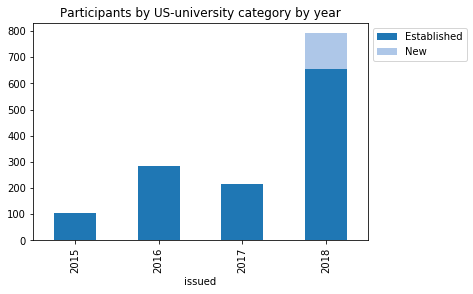

In [34]:
uni_bar = viz[viz.country == 'United States']
uni_bar = pd.DataFrame(uni_bar.groupby(['name', 'issued']).counts.sum()).copy()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)


uni_bar.loc[~uni_bar.name.isin(set_prev_participants), 'name'] = 'New'
uni_bar.loc[uni_bar.name.isin(set_prev_participants), 'name'] = 'Established'
uni_bar = uni_bar.groupby(['name', 'issued']).sum()
uni_bar.columns = ['counts']
uni_bar.reset_index(inplace=True)

uni_bar = uni_bar.pivot(index='issued', columns='name')
uni_bar.columns = uni_bar.columns.droplevel()

#set palette to have unique color for every label
palette = sns.color_palette(palette='tab20', n_colors=uni_bar.T.shape[0])

uni_bar.plot(kind='bar', stacked=True, colormap=ListedColormap(palette))

plt.legend(bbox_to_anchor=(1, 1))
_ = plt.title('Participants by US-university category by year')

From the above graph we can see that many people from inst. that did not previously participate have participated in 2018, the do not account for all of the increase we see in 2018. Inst. that did participate in previous years also sent more people!

We see that a rise of about 200 can be attributed to participants from previously nonrepresented inst. 
This leaves about 300 extra people from inst. that participated in previous years. 

We try to see if we can attribute this to certain universities:

In [35]:
def above_mean_participation(x):
    """returns wether a university is participating more in 2018 than before"""
    return (x[x.issued == 2018].counts > x[x.issued != 2018].counts.median()+x[x.issued != 2018].counts.std())

def account_for(x):
    """Returns number of extra people sent in 2018, as a base participation 
    we take either the median or number of participants in 2016"""

    return x[x.issued == 2018
            ].counts.item() - max(x[x.issued != 2018].counts.median().item(), x[x.issued == 2016].counts.item())

Here we get the universities that seen to have a large increase in participation:

In [36]:
uni_bar = viz[viz.name.isin(set_prev_participants)]
uni_bar.reset_index(inplace=True)
increased_particip = uni_bar.groupby('name').apply(above_mean_participation)
increased_particip = increased_particip[increased_particip == True].reset_index().name.tolist()
increased_particip

['Arizona State University',
 'Carnegie Mellon University',
 'Harvard University',
 'Indiana University at Bloomington',
 'Massachusetts Institute of Technology',
 'New York University',
 'Northwestern University',
 'Rutgers University, Newark',
 'Stanford University',
 'Tufts University',
 'University of California, Berkeley',
 'University of California, Davis',
 'University of California, Los Angeles',
 'University of Colorado at Boulder',
 'University of Illinois at Chicago',
 'University of Illinois at Urbana-Champaign',
 'University of Maryland, College Park',
 'University of Michigan - Ann Arbor',
 'University of Minnesota - Twin Cities',
 'University of Pennsylvania',
 'University of Texas at Austin',
 'University of Washington',
 'University of Wisconsin - Madison',
 'Utah State University',
 'Vanderbilt University']

In [37]:
increase = uni_bar[uni_bar.name.isin(increased_particip)].groupby('name').apply(account_for).reset_index()
increase.sort_values(by=0, ascending=False)

name     0
8                          Stanford University  32.0
6                      Northwestern University  26.0
14           University of Illinois at Chicago  23.0
13           University of Colorado at Boulder  20.0
1                   Carnegie Mellon University  20.0
0                     Arizona State University  17.0
17          University of Michigan - Ann Arbor  17.0
4        Massachusetts Institute of Technology  17.0
24                       Vanderbilt University  16.5
12       University of California, Los Angeles  14.0
3            Indiana University at Bloomington  13.0
21                    University of Washington  12.0
9                             Tufts University  11.0
5                          New York University  10.0
7                   Rutgers University, Newark   8.0
16        University of Maryland, College Park   7.0
19                  University of Pennsylvania   7.0
23                       Utah State University   7.0
15  University of Illinois at Urbana-Champaign   6.0
18       University of Minnesota - Twin Cities   6.0
10          University of California, Berkeley   3.0
20               University of Texas at Austin   3.0
2                           Harvard University   2.0
11             University of California, Davis   1.5
22           University of Wisconsin - Madison   1.0

In [38]:
increase[0].sum()

300.0

We see that the extra participants from these universities would account for the around 300 extra people, giving more comprehensive view of what happend in 2018. 
1. more participants from previously not attending universities attened
2. certain universities sent a lot more people to attend

We will later use the graphs of coauthors to get even more insight into how these new people participated. Did they collaborate with somebody that was already present in previous years?

# Looking at where people collaborate:

## Building a collaboration graph, only taking into consideration countries:

We use the author index to match up author names with indices:

In [39]:
pub_collab = associations[['file','country', 'name']].drop_duplicates()
collabs = pd.merge(pub_collab, pub_collab, on='file').drop_duplicates()
collabs.dropna(inplace=True)
collabs.head()

file      country_x                             name_x  \
0  import2018_371  United States  University of Colorado at Boulder   
1  import2018_417  United States  Indiana University at Bloomington   
2  import2018_417  United States  Indiana University at Bloomington   
3  import2018_417  United States                 Indiana University   
4  import2018_417  United States                 Indiana University   

       country_y                             name_y  
0  United States  University of Colorado at Boulder  
1  United States  Indiana University at Bloomington  
2  United States                 Indiana University  
3  United States  Indiana University at Bloomington  
4  United States                 Indiana University

Building collaboration graph:

In [40]:
nodes = pd.DataFrame(collabs.country_x.dropna().unique())
nodes.columns = ['country']
nodes.reset_index(inplace=True)
nodes.head()

index         country
0      0   United States
1      1         Germany
2      2  United Kingdom
3      3       Singapore
4      4          Canada

In [41]:
country_index = nodes.country.to_dict()
country_index = {v: k for k, v in country_index.items()}

collabs['index_x'] = collabs.country_x.map(country_index)
collabs['index_y'] = collabs.country_y.map(country_index)

edges = collabs[['index_x', 'index_y']].copy()

In [42]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.index_x), int(row.index_y)
        adjacency[i, j] += 1
        adjacency[j, i] = adjacency[i, j]


    return adjacency

In [43]:
adjacency = get_adjacency(nodes, edges)

In [44]:
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.country.to_dict()

## Most collaborative countries

The number represented is: number of different papers written in collaboration with an other country.
Clearly, as the owerall number of papers for the us is extremly hight, the US will dominate this graph:

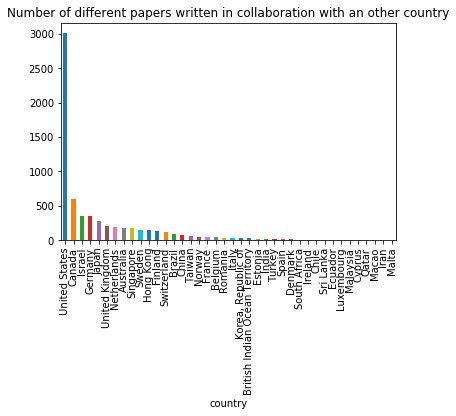

In [45]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
plt.title('Number of different papers written in collaboration with an other country')
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

What country has most collaborations with different countries?
That the number on the y axis is the number of countries the country on the x axis collaborates with: 

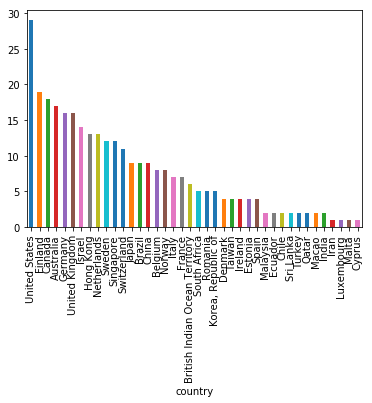

In [46]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('country').degrees.sort_values(ascending=False).plot(kind='bar')

## Isolated Countries

In [47]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
nodes.iloc[zero_collabs]

index     country  degrees
21     21        Iran        1
27     27  Luxembourg        1
28     28       Malta        1
36     36      Cyprus        1

## Looking at the countries that do collaborate:

The total number of connected components (including isolated nodes) is:

In [48]:
nx.number_connected_components(graph)

5

**Hence all other countries are part of the main component.**

To more easely visualize the graph we extract the largest component and try to partition/cluster the graph in some way. Here we use the kernighan lin bisection algorithm to find a bisection. The bisection groupy the countries into countries with a lot of collaboration and little collaboration.

In [49]:
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_cc)

In [50]:
#remove countries not in largest component
mapping = {k:mapping[k] for k in largest_cc if k in mapping}

In [51]:
from networkx.algorithms.community import kernighan_lin_bisection
c = list(kernighan_lin_bisection(graph))

In [52]:
def matching_by_criteria(c):
    member_label = {}
    for index, community in enumerate(c):
        members = list(community)
        for m in members:
            member_label[m] = index
    return member_label

country_partition = matching_by_criteria(c)

Change size of nodes based on with how many other countries a country interacts:

We use degree centrality, which will be large for countries with a lot of collaboration and small for countries with little collaboration.

In [53]:
node_size = (np.array(list(nx.degree_centrality(graph).values())))*1500
edge_color= np.array(list(nx.get_edge_attributes(graph, 'weight').values()))

Unify color palette using the following code:

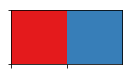

In [54]:
palette = sns.color_palette(palette='Set1', n_colors=2)

sns.palplot(palette)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


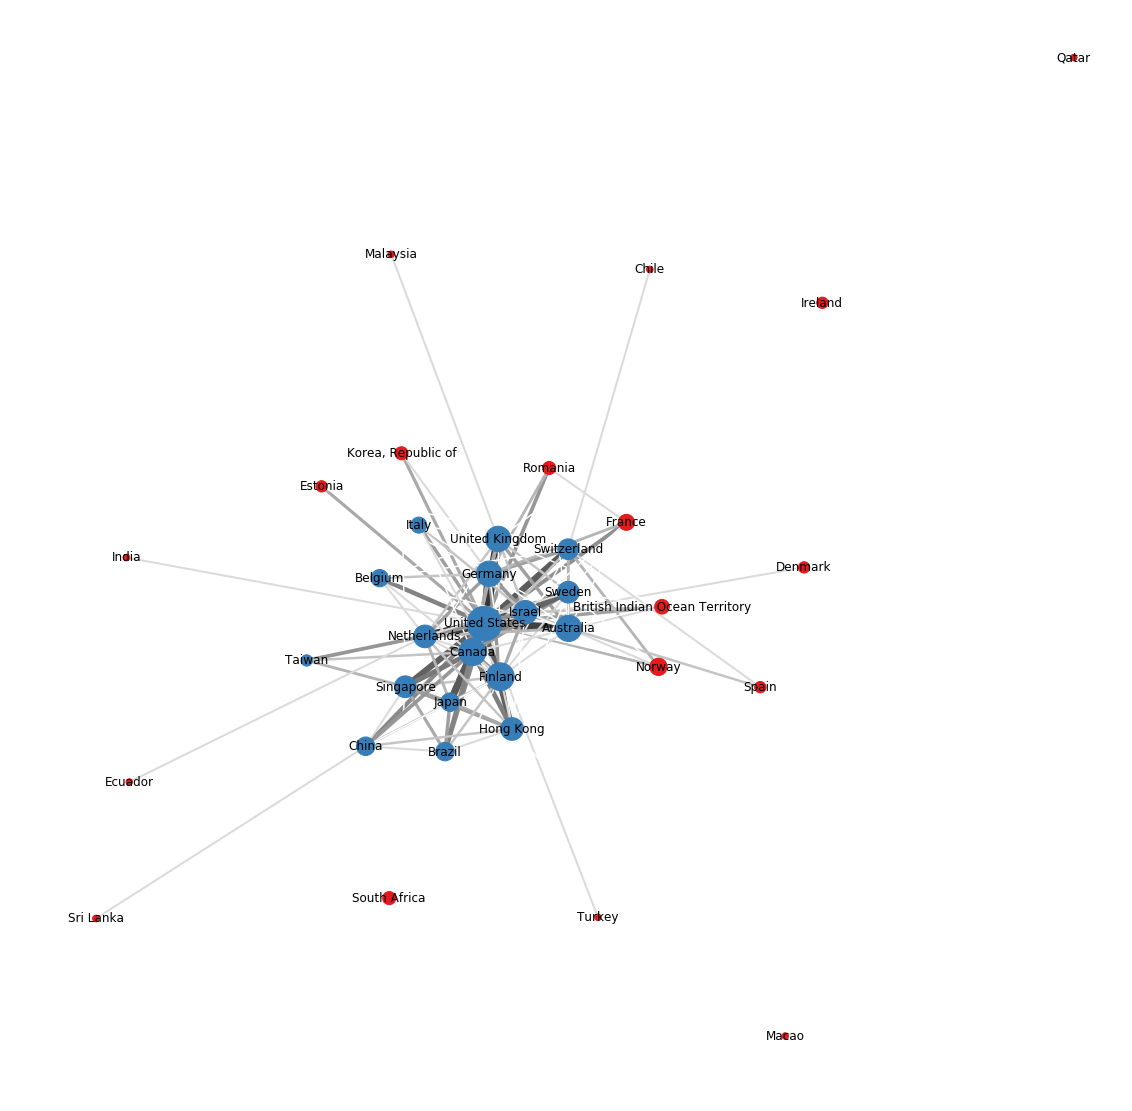

In [55]:
plt.figure(figsize=(15, 15))
nx.draw_spring(graph, 
               #edge_color='grey', 
               node_color=pd.Series(country_partition).sort_index().tolist(),
               width = np.sqrt(edge_color),
               edge_color = np.log(edge_color),
               edge_cmap = plt.cm.gray_r,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=node_size, 
               labels=mapping)

We see that we have a hub in which countries collaborate strongly within each other, and to which less collaborative countries connect to, giving us a star-like structure.

An alternative visualization for the graph using the adjacency matrix. In the below picture, a black dot represents a connection between the countries listed on the x, resp. y axis. It can give us a direct look at the overall community structure, again showing that we have a group of regulars in the center, with less collaborative countries at the fringes.

In [56]:
reordering = [ j for j, i in country_partition.items()]

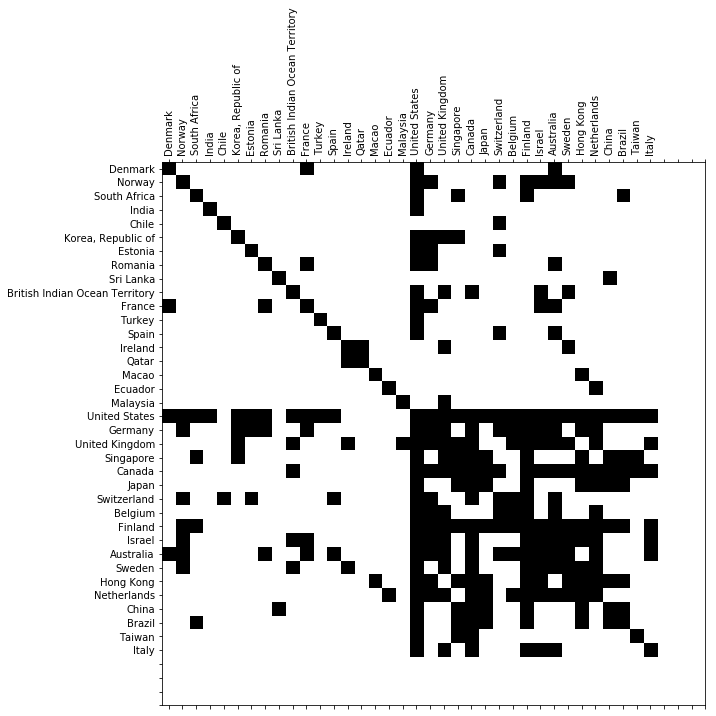

In [57]:
plt.figure(figsize=(10, 10))
plt.spy(adjacency[reordering][:, reordering])
plt.xticks(np.arange(nodes.shape[0]), nodes.country.iloc[reordering], rotation=90)
_ = plt.yticks(np.arange(nodes.shape[0]), nodes.country.iloc[reordering])

Same but with weigthed edges indicating the strength of collaboration:

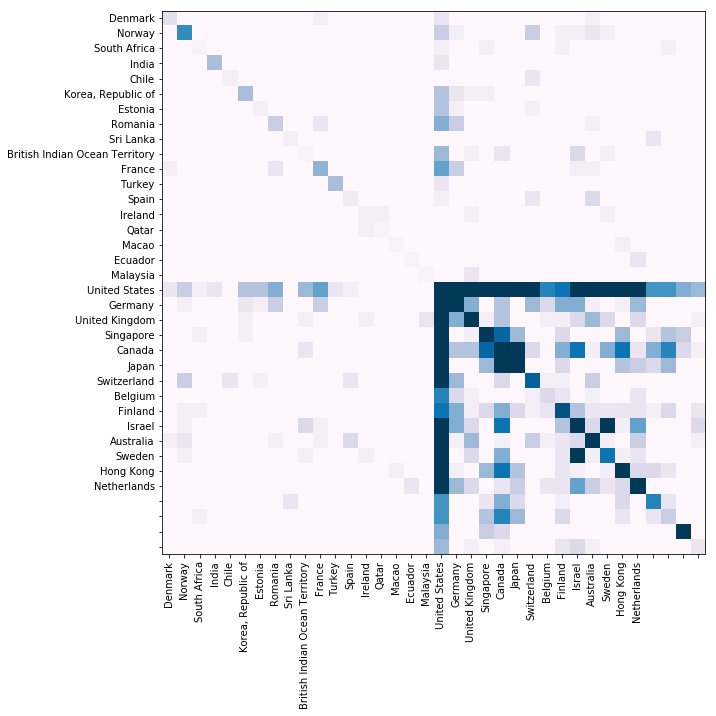

In [58]:
plt.figure(figsize=(10, 10))
plt.imshow(adjacency[reordering][:, reordering], vmin=0, vmax=30, cmap=plt.cm.PuBu)
plt.xticks(np.arange(nodes.shape[0]-4), nodes.iloc[reordering].country.iloc[:-4], rotation=90)
_ = plt.yticks(np.arange(nodes.shape[0]-4), nodes.iloc[reordering].country.iloc[:-4])

# Looking at collaborating between universities:

Find who collaborated with whom on a paper and turn the resulting edge list into a graph:

In [59]:
pub_collab = associations[['file','name', 'country']].drop_duplicates()
pub_collab = pub_collab[pub_collab.name != 'gmail']
collabs = pd.merge(pub_collab, pub_collab, on='file').drop_duplicates()

#collabs = collabs[collabs.name_x != collabs.name_y]

nodes = pd.DataFrame(collabs.name_x.dropna().unique())
nodes.columns = ['name']
nodes.reset_index(inplace=True)

In [60]:
uni_index = nodes.name.to_dict()
uni_index = {v: k for k, v in uni_index.items()}

collabs['index_x'] = collabs.name_x.map(uni_index)
collabs['index_y'] = collabs.name_y.map(uni_index)

edges = collabs[['index_x', 'index_y']].dropna()

In [61]:
adjacency = get_adjacency(nodes, edges)
n_nodes = len(nodes)
graph = nx.from_numpy_array(adjacency - np.identity(n_nodes)*adjacency)
mapping = nodes.name.to_dict()

H=nx.relabel_nodes(graph,mapping)

### Most collaborative universities:

Again we answer basic quantitative questions about the number of collaborations:

**Number of different papers written in collaboration with an other university.**

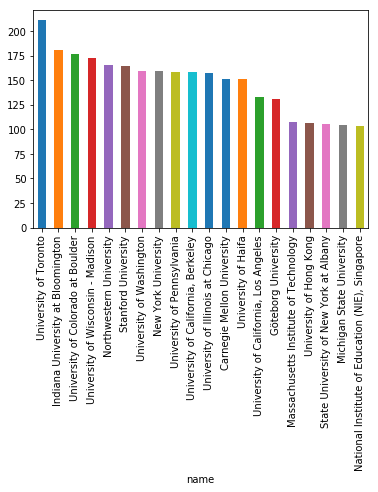

In [62]:
nodes['degrees'] = pd.Series(adjacency.sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

Number of distinct different institution collbaorations:
The number on the y axis is the number of different institutions a university collaborated with (without counting how often the did this.)

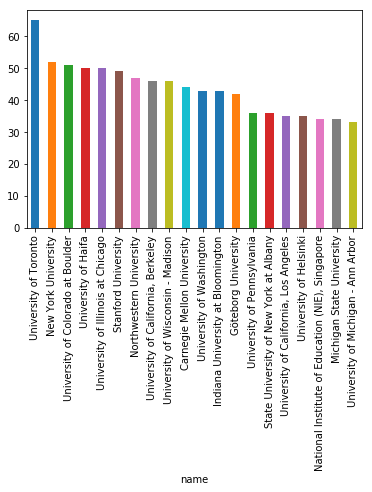

In [63]:
nodes['degrees'] = pd.Series(np.where(adjacency > 0, 1, 0).sum(axis=1))
nodes.set_index('name').degrees.sort_values(ascending=False).head(20).plot(kind='bar')

## Isolated universities:

Analyzing Universities that have not collaborated with other universities:

In [64]:
zero_collabs = np.where((adjacency - adjacency*np.identity(n_nodes)).sum(axis=1) == 0)
zero_collabs[0].shape

(42,)

In [65]:
country_uni_df =  pd.merge(nodes, universities, on='name', how='left')[['name', 'country', 'degrees', 'index']].drop_duplicates()

In [66]:
country_uni_df[country_uni_df['index'].isin(zero_collabs[0])]

name             country  \
1287                                  Aarhus University             Denmark   
1897                                Brandeis University       United States   
2070             University of Massachusetts at Amherst       United States   
2482                        Aalborg University, Denmark             Denmark   
2576                  University of Missouri - Columbia       United States   
2585                          Oklahoma State University       United States   
2591                                 Harding University       United States   
2636                         Tarbiat Modares University                Iran   
2637                               Stockholm University              Sweden   
2705                                 Hanyang University  Korea, Republic of   
2878                    Georgia Institute of Technology       United States   
2931                               University of Geneva         Switzerland   
2960                                             WestEd                 NaN   
2966                        College of William and Mary       United States   
3002                                University of Malta               Malta   
3013                                               ITEC             Belgium   
3118                                      Smith College       United States   
3125                            University of Groningen         Netherlands   
3128             Texas A&M University - College Station       United States   
3190                                Boğaziçi University              Turkey   
3218                          University of Connecticut       United States   
3219                       Saint John's University (NY)       United States   
3229             Korea National University of Education  Korea, Republic of   
3231  SRI International, Center for Technology and L...                 NaN   
3241                            University of Cambridge      United Kingdom   
3249                            Ewha Women's University  Korea, Republic of   
3265            State University of New York at Buffalo       United States   
3299                              Kent State University       United States   
3300               IBM Thomas J. Watson Research Center                 NaN   
3309                              University of Florida       United States   
3318                        Central Michigan University       United States   
3321                                   Grinnell College       United States   
3323                    Cyprus University of Technology              Cyprus   
3359                                 Cardiff University      United Kingdom   
3362                                    Lund University              Sweden   
3364                University of New Hampshire, Durham       United States   
3366                                              CEFET              Brazil   
3369                    University of Northern Colorado       United States   
3390                         Montclair State University       United States   
3412                        City University of New York       United States   
3432                                          KU Leuven             Belgium   
3453   Homi Bhabha Centre for Science Education, Mumbai                 NaN   

      degrees  index  
1287        1     40  
1897        1     68  
2070        1     76  
2482        1     99  
2576        1    109  
2585        1    110  
2591        1    114  
2636        1    122  
2637        1    123  
2705        1    133  
2878        1    151  
2931        1    163  
2960        1    169  
2966        1    170  
3002        1    182  
3013        1    184  
3118        1    212  
3125        1    216  
3128        1    217  
3190        1    244  
3218        1    258  
3219        1    259  
3229        1    263  
3231        1    265  
3241        1    269  
3249        1    272  
3265        1    280  
3299     

Looking at what countries these universities are in:

In [67]:
country_uni_df[country_uni_df['index'].isin(zero_collabs[0])].country.value_counts()

United States         20
Korea, Republic of     3
Sweden                 2
United Kingdom         2
Belgium                2
Denmark                2
Turkey                 1
Netherlands            1
Malta                  1
Iran                   1
Switzerland            1
Cyprus                 1
Brazil                 1
Name: country, dtype: int64

## Analyzing main group of universities interacting:

We only look at largest component and ignore universities that don't belong to the main cluster

In [68]:
components = nx.connected_components(graph)
largest_cc = max(components, key=len)

main_universities = graph.subgraph(largest_cc)

Number of components of universities that collaborate outside of main cluster:

In [69]:
nx.number_connected_components(graph) - zero_collabs[0].shape[0]-1

10

We look at the smaller connected components with at least 3 nodes:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


185            Shandong University
186     Liaoning Normal University
187    National Science Foundation
Name: name, dtype: object


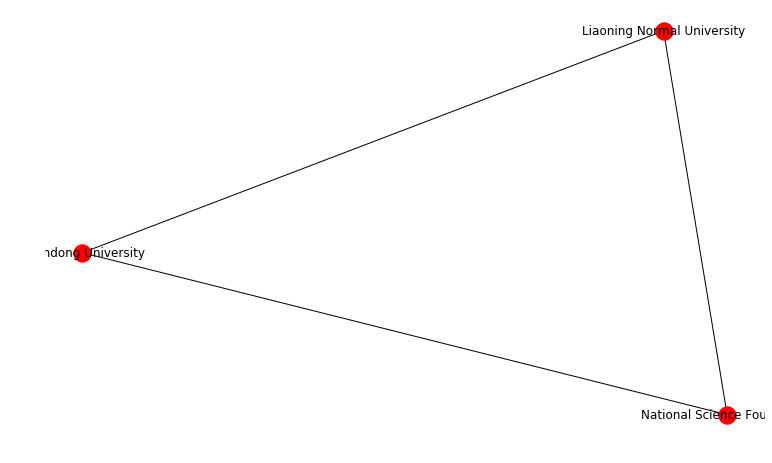

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


256       Wake Forest University
257    Missouri State University
255    Illinois State University
Name: name, dtype: object


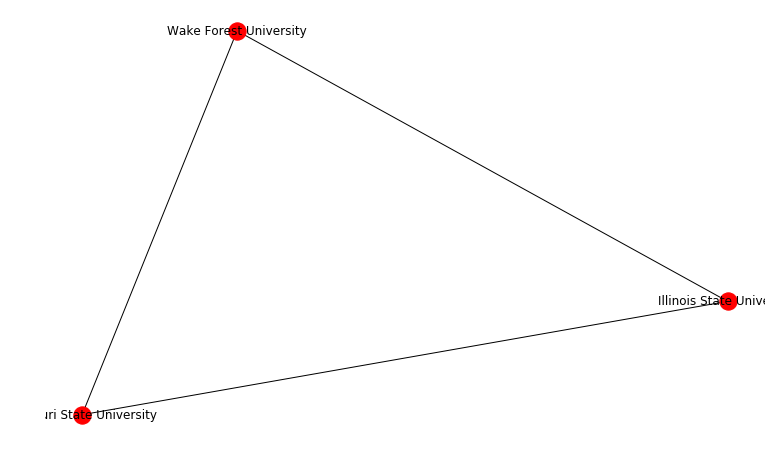

In [70]:
for g in list(nx.connected_component_subgraphs(graph)):
   
    if len(g.nodes) > 2 and len(g.nodes) < len(largest_cc):
        plt.figure(figsize=(10, 6))
        nx.draw_spring(g, labels=nodes.iloc[list(g.nodes)].name.to_dict())
        print(nodes.iloc[list(g.nodes)].name)
        plt.show()

### Main component

We partition the nodes to find "communities" of universities. They are the colored with the same color

In [71]:
from networkx.algorithms.community import greedy_modularity_communities
partition = list(greedy_modularity_communities(main_universities))
uni_partition = matching_by_criteria(partition)

Our partitioning algorthims finds 14 communities:

In [72]:
len(partition)

16

Change size of nodes based on with how many other countries a country interacts: the more connections the other nodes it has the larger the node will be.


For readability only nodes with some of the largest values –universities who are at the center of collaboration– are labeled. 

In [73]:
node_size = np.array(list(nx.degree_centrality(main_universities).values()))
edge_width = np.array(list(nx.get_edge_attributes(main_universities, 'weight').values()))

In [74]:
np.sqrt(edge_width).max()

4.69041575982343

In [75]:
nodes.loc[list(largest_cc),'node_size'] = node_size
labels = nodes.iloc[list(largest_cc)][nodes.node_size > np.percentile(node_size, 97.5)].name

/anaconda3/envs/Biblio/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


The color pallete for each cluster corresponds to the following cluster number:

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15  ||  16


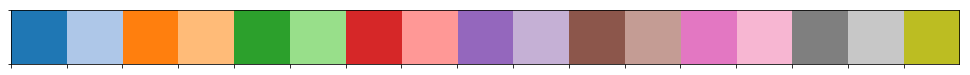

In [76]:
palette = sns.color_palette(palette='tab20', n_colors=len(partition)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(partition)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


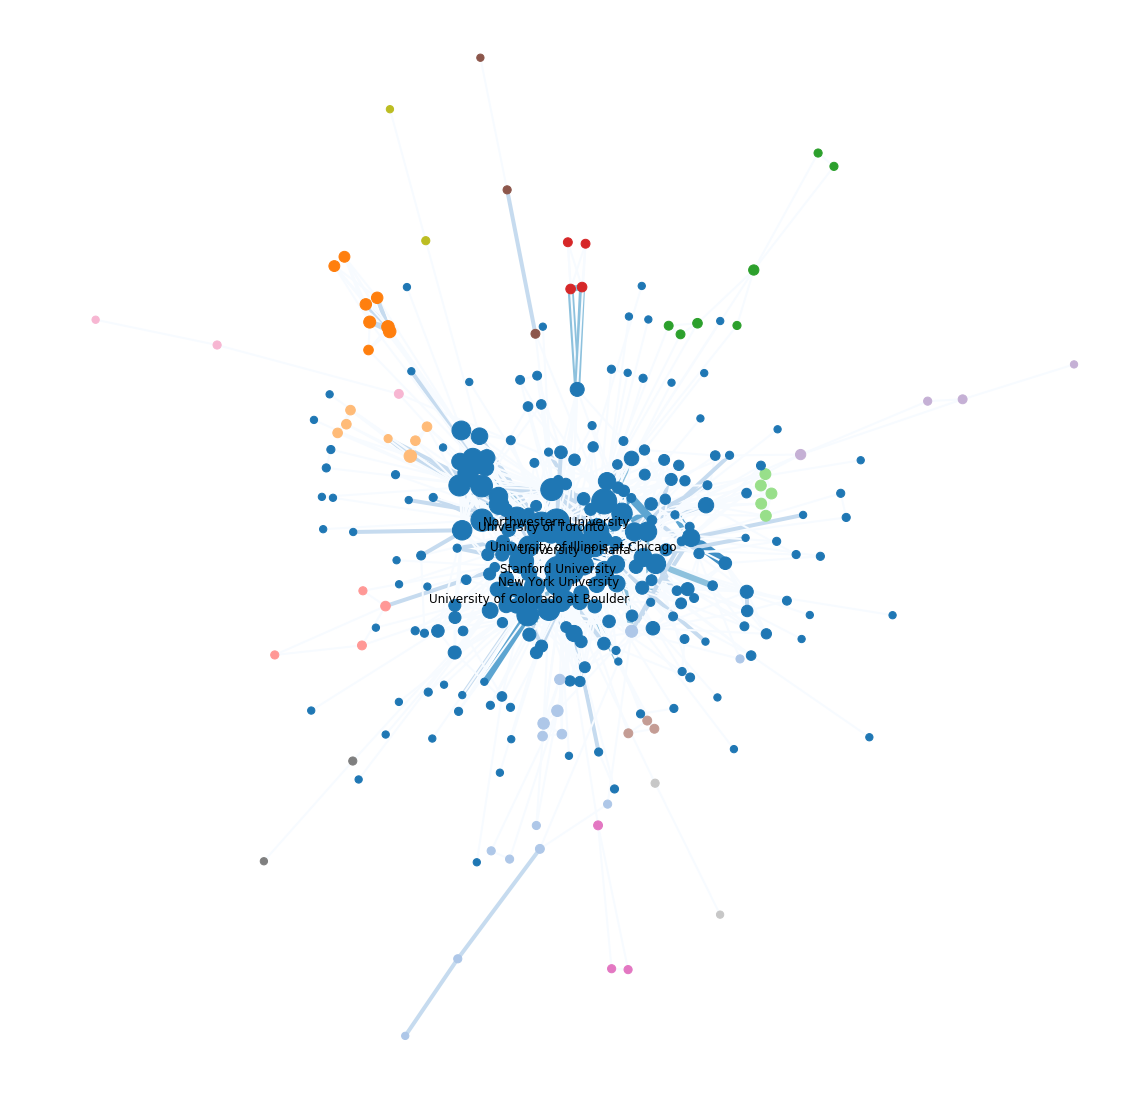

In [77]:
plt.figure(figsize=(15, 15))
nx.draw_spring(main_universities,  #edge_color='grey', 
               node_color=pd.Series(uni_partition).sort_index().tolist(),
               width = edge_width,
               edge_color = np.log(edge_width+1),
               edge_cmap = plt.cm.Blues,
               cmap=ListedColormap(palette.as_hex()), 
               node_size=(node_size+0.01)*4000, 
               labels=labels.to_dict(),
               iterations=5000
              )

The most collaboration friendly unis according to degree centrality are:

In [78]:
labels

0     University of Colorado at Boulder
18    University of Illinois at Chicago
19                University of Toronto
26                  New York University
60                  University of Haifa
85                  Stanford University
86              Northwestern University
Name: name, dtype: object

In [79]:
nodes[['Lon', 'Lat']] = pd.merge(nodes, universities, on='name', 
                  how='left')[[ 'name',  'Lon', 'Lat']].drop_duplicates().reset_index(drop=True)[['Lon', 'Lat']]

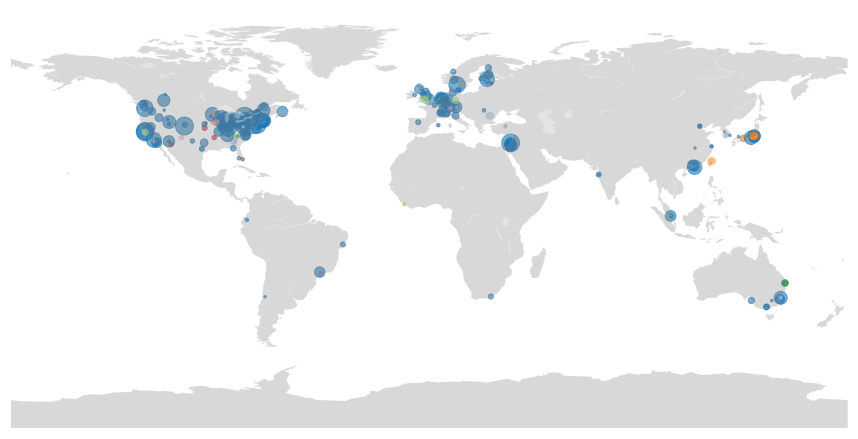

In [80]:
plt.figure(figsize=(15, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(largest_cc)].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'], s=node_size*2000, c=pd.Series(uni_partition).sort_index().tolist(), 
          cmap=ListedColormap(palette.as_hex()), alpha=0.6)


The Universities in each cluster are:

Cluster number:  1


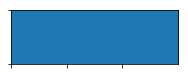

['University of Colorado at Boulder', 'Indiana University at Bloomington', 'Indiana University', 'Technische Universität München', 'Universität Augsburg', 'Ludwig-Maximilians-Universität München', 'University of Edinburgh', 'San Jose State University', 'Harvard University', 'Vanderbilt University', 'University College London, University of London', 'University of Illinois at Chicago', 'University of Toronto', 'Tokyo University', 'Pennsylvania State University', 'New York University', 'Simon Fraser University', 'EPFL - EPF Lausanne', 'Ghent University', 'University of Jyväskylä', 'Swiss Federal Institute for Vocational Education and Training', 'University of Wisconsin - Madison', 'Arizona State University', 'Hebrew University of Jerusalem', 'University of Texas at Austin', 'University of Maryland, College Park', 'University of California, Berkeley', 'Utah State University', 'University of Washington', 'University of Nottingham', 'DePaul University', 'Shizuoka University', 'State Univers

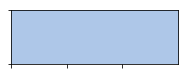

['University Politehnica of Bucharest', 'Georgia State University', 'Ankara University', 'Texas State University', 'Middle East Technical University', 'Virginia Commonwealth University', 'Korea Advanced Institute of Science & Technology', 'Drexel University', 'Worcester Polytechnic Institute', 'University of Warwick', 'Macquarie University', 'Mercer University', 'National University of Singapore', 'Universität der Bundeswehr München, Germany']
Cluster number:  3


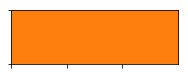

['Yokohama National University', 'The Open University of Japan', 'Senshu University', 'Kobe University', 'Utsunomiya University', 'Ibaraki University', 'Tokyo Gakugei University', 'Soka University']
Cluster number:  4


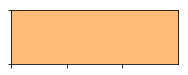

['National Chengchi University', 'National Taichung University of Science and Technology, Taiwan', 'National Hsinchu University of Education', 'National Central University', 'National Taiwan Normal University', 'National Tsinghua University', 'National Taiwan University of Science and Technology']
Cluster number:  5


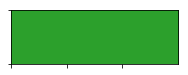

['Griffith University', 'Open University', 'Maastricht University', 'University of Technology Sydney', 'Queensland University of Technology', 'James Cook University of North Queensland', 'Warren Wilson College']
Cluster number:  6


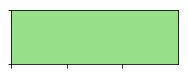

['Bauhaus Universität Weimar', 'University of Southampton', 'University of the West of England, Bristol', 'McGraw-Hill Education', 'Google Inc.']
Cluster number:  7


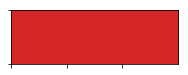

['University of Central Arkansas', 'Kansas State University', 'Universität Köln', 'Rochester Institute of Technology']
Cluster number:  8


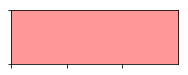

['University of California, Irvine', 'University of Chicago', 'Central College', 'University of Iowa']
Cluster number:  9


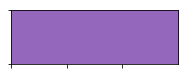

['Knowledge Media Research Center', 'Practice for Giftedness and High Achievement Potential', 'Eberhard-Karls-Universität Tübingen', 'Universität Konstanz']
Cluster number:  10


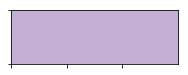

['University of Miami', 'University of Maine System', 'University of Arizona']
Cluster number:  11


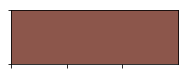

['State University of New York at Binghamton', 'Minneapolis Institute of Art', 'Science Museum of Minnesota']
Cluster number:  12


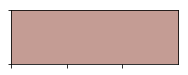

['Educational Testing Service', 'Sony Interactive Entertainment', 'Universidade de São Paulo']
Cluster number:  13


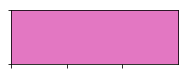

['University of Southern Denmark - SDU', 'University of New Mexico', 'Ohio State University, Columbus']
Cluster number:  14


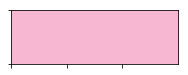

['Temple University', 'University of Delaware']
Cluster number:  15


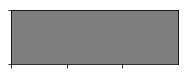

['University of Georgia', 'West Virginia University']
Cluster number:  16


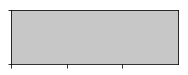

['Nanyang Technological University', 'Ministry of Education']


In [81]:
for i, m in enumerate(list(greedy_modularity_communities(main_universities))):
    unis = nodes.iloc[list(m)]
    unis = unis[unis.name.map(lambda x: True if reg.search('\p{Lu}',x) else False)].name.unique().tolist() 
    if len(unis) > 1:
        print('Cluster number: ', i+1)
        sns.palplot(palette[i])
        plt.show()
        print(unis)

# Looking at co authorship, taking into consideration country and inst.

We use the associations frame again to build a co-authorship graph based on people with attributes country and institution

In [82]:
associations.columns
#we can drop one of the file columns
(associations.file != associations.file_y).sum()

0

In [83]:
del associations['file_y']

In [84]:
associations = associations[associations.country.notna()]

In [85]:
self_merge = pd.merge(associations, associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = associations[~associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

In [86]:
edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)

adjacency = get_adjacency(nodes, edges)
graph = nx.from_numpy_array(adjacency)

Adding attributes to the graph:

In [87]:
edge_dict = {}
for i, row in edges.iterrows():
    edge_dict[(row['index_x'], row['index_y'])] =  row['issued_x']

In [88]:
nx.set_edge_attributes(graph, edge_dict, name='year')
nx.set_node_attributes(graph, nodes.country.to_dict(), name='country')
nx.set_node_attributes(graph, nodes.name.to_dict(), name='uni')
mapping = nodes.long_name.to_dict()
H=nx.relabel_nodes(graph,mapping)

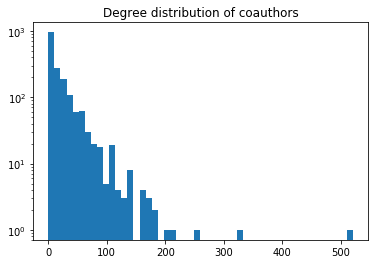

In [89]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

This is a simple drawing of our network: we see that there is a large core communit, and many many smaller comminitues of co authors. We will look more into the main community

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


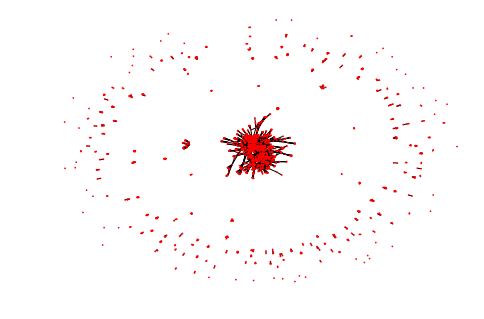

In [90]:
nx.draw(graph, pos=nx.spring_layout(graph), node_size=[0.5,0.5])

In [91]:
embedding = nodes.apply(lambda x: [x.Lon, x.Lat], axis=1)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


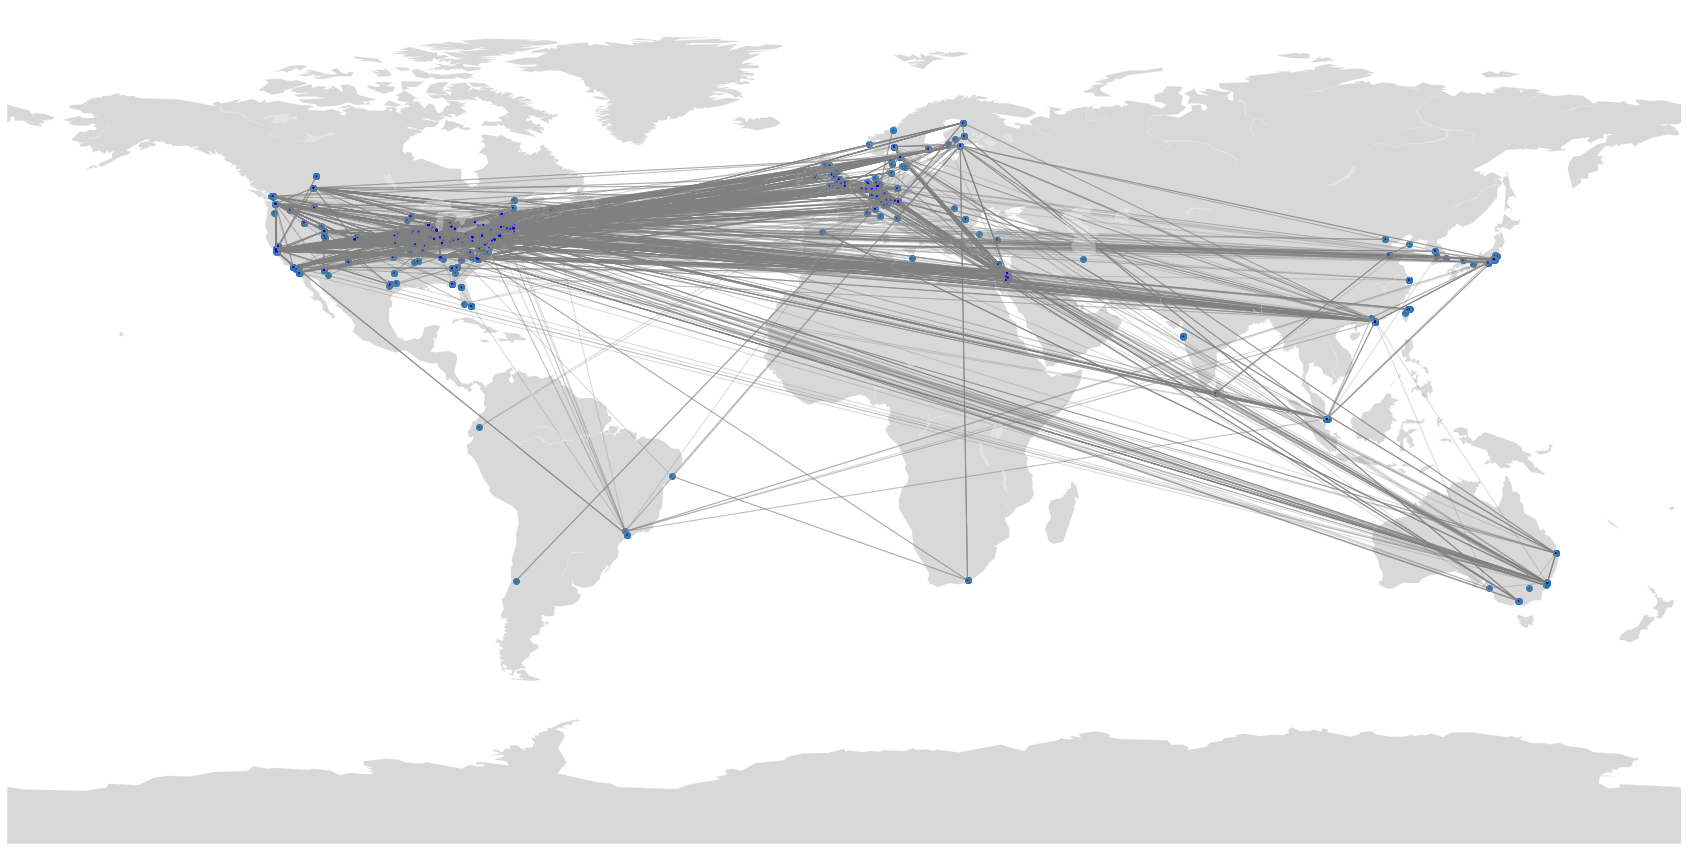

In [92]:

plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'])
nx.draw(graph, node_size=[0.5,0.5], pos = embedding, edge_color='grey', node_color='b', alpha=0.3)


We focus in on the different components:

In [93]:
#get components
components = nx.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)

The total number of components is:

In [94]:
nx.number_connected_components(graph)

206

In [95]:
print(f'the largest component contains : {len(largest_cc)} people')

the largest component contains : 1136 people


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


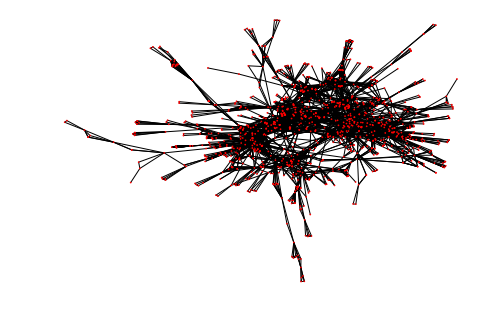

In [96]:
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5])

Drawing it in a geographical embedding:

In [97]:
embedding = nodes.iloc[list(largest_cc)].apply(lambda x: [x.Lon, x.Lat], axis=1)

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


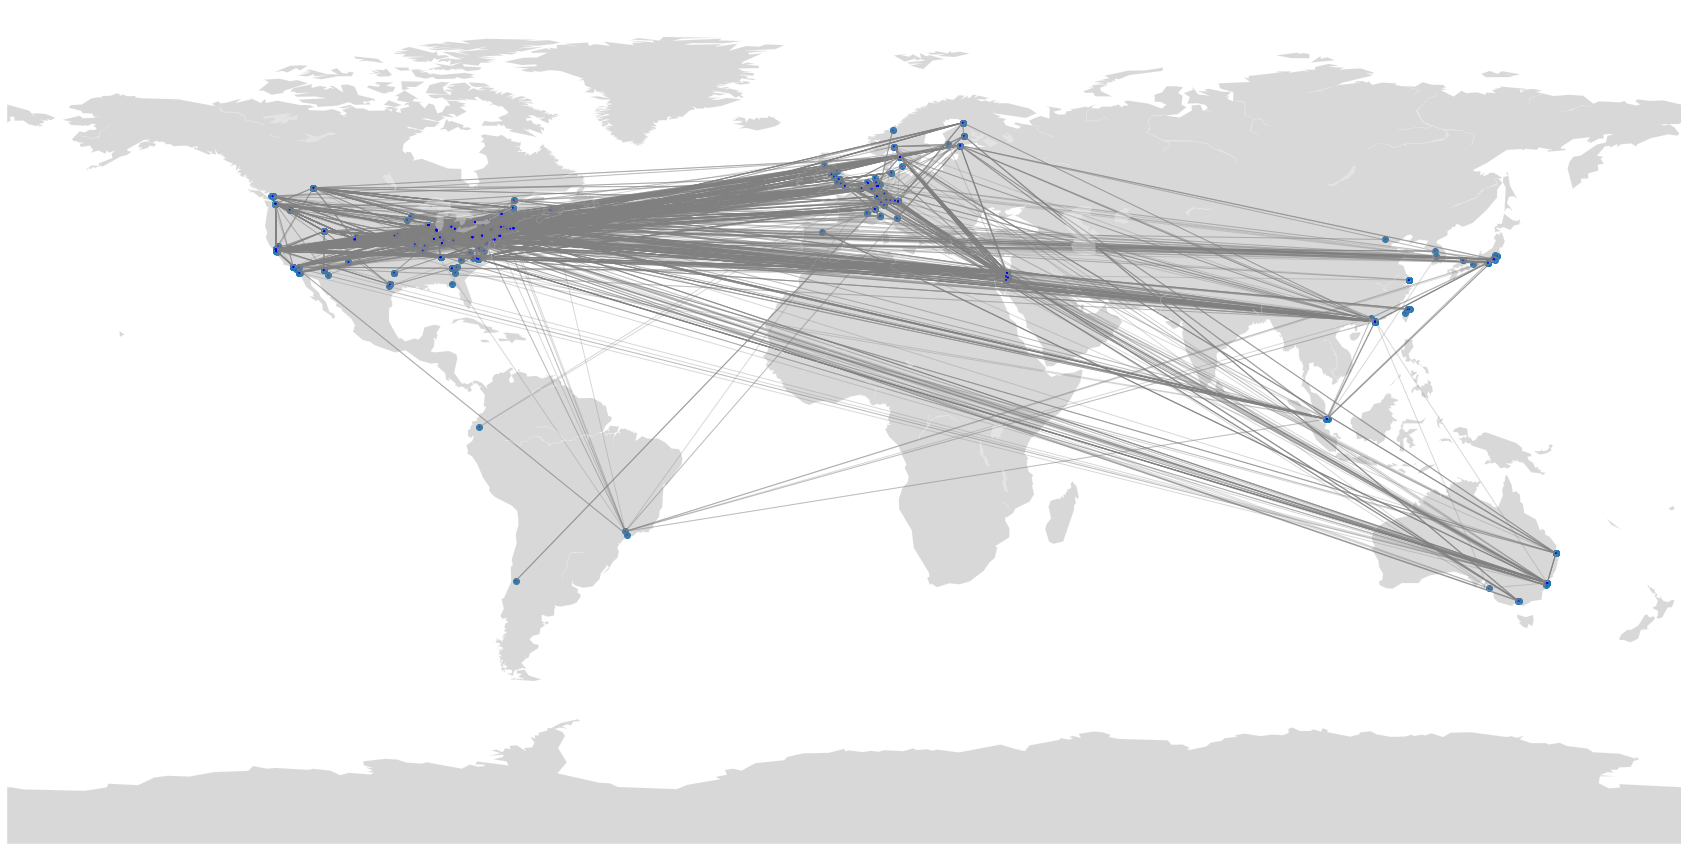

In [98]:
plt.figure(figsize=(30, 20))
m=Basemap()
m.drawmapboundary(linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
data = nodes.iloc[list(largest_cc)].copy()
 
# Add a point per position
m.scatter(data['Lon'], data['Lat'])
nx.draw(graph.subgraph(largest_cc), node_size=[0.5,0.5], pos = embedding, edge_color='grey', node_color='b', alpha=0.3)


### Who colaborates the most:

We can easely find the people who worked with the most other people:
(counting repeat collaboration)

In [99]:
nodes['collabs_weighted'] = adjacency.sum(axis=1)
nodes.sort_values(by='collabs_weighted', ascending=False)[['long_name', 'country', 'name', 'collabs_weighted']].head(10)

long_name        country  \
179         Rummel, Nikol        Germany   
235          Linn, Marcia  United States   
63   Puntambekar, Sadhana  United States   
368         Gerard, Libby  United States   
154   Bielaczyc, Katerine  United States   
233      Vitale, Jonathan  United States   
38       Slotta, James D.         Canada   
388       Abrahamson, Dor  United States   
97         Zhang, Jianwei  United States   
120     Danish, Joshua A.  United States   

                                                  name  collabs_weighted  
179                             Ruhr-University Bochum               520  
235                 University of California, Berkeley               332  
63                   University of Wisconsin - Madison               252  
368                 University of California, Berkeley               208  
154  Hiatt Center for Urban Education, Clark Univer...               200  
233                 University of California, Berkeley               184  
38                               University of Toronto               182  
388                 University of California, Berkeley               172  
97              State University of New York at Albany               172  
120                  Indiana University at Bloomington               170

Same as above but counting person only once:

In [100]:
nodes['collabs_unweighted'] = np.where(adjacency > 0, 1, 0).sum(axis=1)
nodes.sort_values(by='collabs_unweighted', ascending=False)[['long_name', 'country', 'name', 'collabs_unweighted']].head(10)

long_name        country                                    name  \
146        Kali, Yael         Sweden                     Göteborg University   
38   Slotta, James D.         Canada                   University of Toronto   
179     Rummel, Nikol        Germany                  Ruhr-University Bochum   
97     Zhang, Jianwei  United States  State University of New York at Albany   
98      Chen, Mei-Hwa  United States  State University of New York at Albany   
39      Acosta, Alisa         Canada                   University of Toronto   
318     Rosé, Carolyn  United States              Carnegie Mellon University   
605       Bang, Megan  United States                University of Washington   
319     kafai, yasmin  United States              University of Pennsylvania   
460       Chan, Carol      Hong Kong                 University of Hong Kong   

     collabs_unweighted  
146                  63  
38                   61  
179                  61  
97                   59  
98                   54  
39                   54  
318                  53  
605                  51  
319                  50  
460                  49

### Zooming into largest community: - country & institution

In [101]:
main_component = nodes[nodes.index.isin(largest_cc)]

Comparing the country representation in main component to the one overall.

Text(0, 0.5, 'Counts')

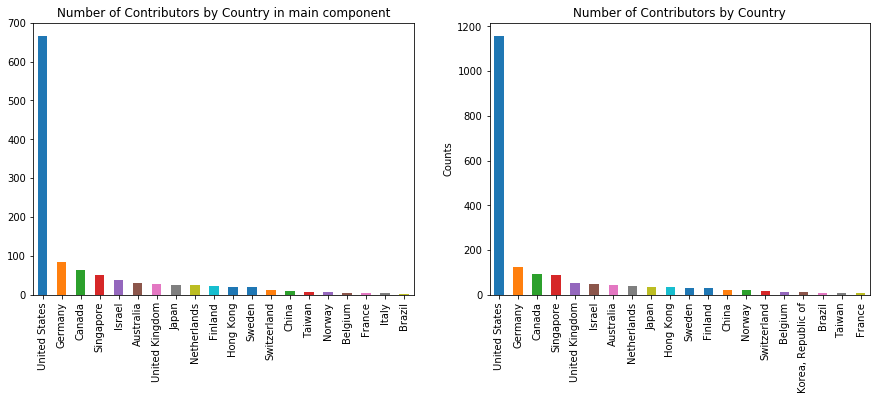

In [102]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Number of Contributors by Country in main component')
main_component.country.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
universities[(~universities.mail.duplicated())].country.value_counts().head(20).plot(kind = 'bar')
plt.title('Number of Contributors by Country') # as determinded by university affiliation
plt.ylabel('Counts')

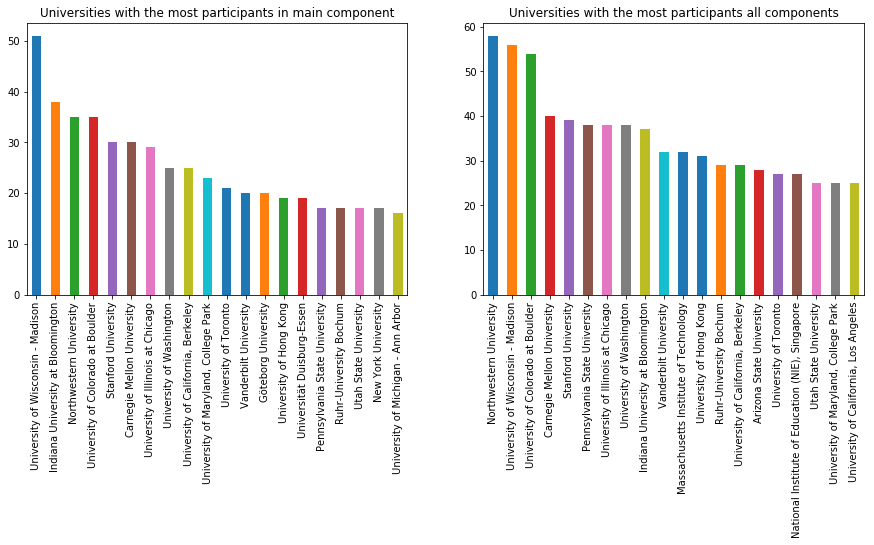

In [103]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
#plt.ylim([0, 60])
plt.title('Universities with the most participants in main component')
main_component.name.value_counts().head(20).plot(kind='bar')
plt.subplot(122)
#plt.ylim([0, 60])
plt.title('Universities with the most participants all components')
universities[(universities.name != 'gmail') & (~universities.mail.duplicated())].name.value_counts().head(20).plot(kind='bar')
plt.show()

## Finding communities in the community: Modularity and Other measures

Constructing the graph with the largest component:

In [104]:
main_component = graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
main_component=nx.relabel_nodes(main_component,mapping)

Here we use modularity to detect communities, which will find subgraph that are unliquely to have developed "randomly".

From wikipedia:

>It was designed to measure the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. Modularity is often used in optimization methods for detecting community structure in networks

In [105]:
c = list(greedy_modularity_communities(main_component))

We find 18 communities in total:

In [106]:
len(c)

19

In [107]:
#smallest community:
min(c, key=len)

frozenset({'Quignard, Matthieu', 'Tchounikine, Pierre', 'Wang, Patrick'})

## Intermezzo: removing duplicate names!

We could use this to elliminate duplicates, merge some people:

The difficulty is to not have any false positives. False negatives are fine, We thus decide to look at similar names **within** the communities we found. Additionaly we check that the same last name is present and exclude some last names (chinese ones) as they are prone to lead to false positives.

In [108]:
#example of duplicates showing up!
metadata[metadata.long_name.isin(['Cuendet, Sebastien', 'Cuendet, Sébastien'])]

file                                            subject  \
1656    import2016full_68                                                NaN   
1742   import2015full_182  ['tangible user interface', 'eye-tracking', 'j...   
1862  import2015short_182  ['tangible user interface', 'eye-tracking', 'j...   

     iso                                       uri          type  \
1656  en             info:doi/10.22318/icls2016.68  Book chapter   
1742  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   
1862  en  https://doi.dx.org/10.22318/cscl2015.182  Book chapter   

                                              publisher  \
1656  Singapore: International Society of the Learni...   
1742   International Society of the Learning Science...   
1862   International Society of the Learning Science...   

                                                  title  issued  \
1656  Detecting Collaborative Dynamics Using Mobile ...    2016   
1742  3D Tangibles Facilitate Joint Visual Attention...    2015   
1862  3D Tangibles Facilitate Joint Visual Attention...    2015   

             accessioned                                           citation  \
1656 2017-03-21 12:05:42  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1742 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   
1862 2017-06-19 14:15:51  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   

               available                                           abstract  \
1656 2017-03-21 12:05:42  Prior work has successfully described how low ...   
1742 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   
1862 2017-06-19 14:15:51  We report results from a dual eye-tracking stu...   

                long_name  author_order shortend_names  \
1656   Cuendet, Sebastien             2      Sharma K.   
1742  Cuendet, Sébastien             2      Sharma K.   
1862  Cuendet, Sébastien             2      Sharma K.   

                                             identifier           merge_index  
1656  Schneider, B., Sharma, K., Cuendet, S., Zuffer...    import2016full_682  
1742  Schneider, B., Sharma, K., Cuendet, S., Zuffer...   import2015full_1822  
1862  Schneider, B., Sharma, K., Cuendet, S., Zuffer...  import2015short_1822

Number of members before uniformisation:

In [109]:
import difflib
import unicodedata


def find_name_matching(c, threshold = 0.8, last_names_to_ignore = ['zhang', 'chen', 'liu', 'wang']):
    """finds different spellings of same name and gives mapping to create one person one name"""
    d = {}
    for community in c:
        members = list(community)
        for i, member in enumerate(members):
            for j, member_2 in enumerate(members):
                if i < j:
                    difference = difflib.SequenceMatcher(None, member, member_2).ratio()
                    if difference > threshold:
                        last_1 =reg.search('[\p{L}]*', unicodedata.normalize('NFC', member.lower())).group(0)
                        last_2 = reg.search('[\p{L}]*', unicodedata.normalize('NFC', member_2.lower())).group(0)
                        same_last_name = reg.search('[\p{L}]*', 
                                                    member.lower()).group(0) == reg.search(
                            '[\p{L}]*', member_2.lower()).group(0)
                        if same_last_name and last_1 not in last_names_to_ignore  and not member_2 in d.keys():
                            d[member_2] = member
    return d

d = find_name_matching(c)
len(d)

19

In [110]:
d

{'Azevedo, Flávio S.': 'Azevedo, Flavio S.',
 'Chan, Carol K.K.': 'Chan, Carol',
 'Cuendet, Sebastien': 'Cuendet, Sébastien',
 'Davis, Richard': 'Davis, Richard Lee',
 'Dornfeld, Catherine': 'Dornfeld, Catherine L.',
 'D’Angelo, Sarah': "D'Angelo, Sarah",
 'Eagan, Brendan': 'Eagan, Brendan R.',
 'Greenhow, Chrisine': 'Greenhow, Christine',
 'Keifert, Danielle Teodora': 'Keifert, Danielle',
 'Lee, Victor R.': 'Lee, Victor',
 'Levy, Sharona T': 'Levy, Sharona T.',
 'Madhok, Jacqueline': 'Madhok, Jacquie',
 'Penuel, William': 'Penuel, Bill',
 'Quintana, Rebecca': 'Quintana, Rebecca M',
 'Schunn, Chris': 'Schunn, Christian',
 'Severance, Samuel': 'Severance, Sam',
 'Shareff, Rebecca': 'Shareff, Becca',
 'Sheldon, Josh': 'Sheldon, Joshua',
 'Wu, Sally P.W.': 'Wu, Sally P. W.'}

Reason why we normalize the string:

In [111]:
ord(u'ä')

228

In [112]:
for c in u"ä":
    print(repr(c), ord(c))

'a' 97
'̈' 776


In [113]:
improved_associations = associations.copy()

In [114]:
improved_associations.loc[improved_associations.long_name.map(d).notna(), 'long_name'] = improved_associations.long_name.map(d)

In [115]:
self_merge = pd.merge(improved_associations, improved_associations, on='file')
self_merge = self_merge[self_merge.long_name_x != self_merge.long_name_y]

edges = self_merge[['long_name_x', 'long_name_y', 'issued_x']].copy()

nodes = improved_associations[~improved_associations.long_name.duplicated()].reset_index(drop=True).reset_index()

name_index = nodes.long_name.to_dict()
name_index = {v: k for k, v in name_index.items()}

edges['index_x'] = edges.long_name_x.map(name_index)
edges['index_y'] = edges.long_name_y.map(name_index)


new_graph = nx.from_numpy_array(get_adjacency(nodes, edges))


components = nx.connected_components(new_graph)
largest_cc = max(nx.connected_components(new_graph), key=len)

In [116]:
main_component = new_graph.subgraph(largest_cc)
mapping = nodes.long_name.to_dict()
#main_component=nx.relabel_nodes(main_component,mapping)

## clique detection:


Here we look at large groups of researchers that all have collaborated within eachother.
We look at groups of at least 15 people:

In [117]:
main_component_ =nx.relabel_nodes(main_component, mapping)
large_cliques = [l for l in list(nx.find_cliques(main_component_)) if len(l) > 15]

In [118]:
large_cliques[0]

['Sorensen, Clara',
 'Rutstein, Daisy',
 'Sherman, Mark A',
 'Lee, Irene',
 'Lui, Debora',
 'Wilensky, Uri',
 'Horn, Mike',
 'Mustafaraj, Eni',
 'kafai, yasmin',
 'Tissenbaum, Mike',
 'Weintrop, David',
 'Shear, Linda',
 'Abelson, Hal',
 'Jayathirtha, Gayithri',
 'Sheldon, Joshua',
 'Shaw, Mia',
 'Shapiro, R. Benjamin',
 'Jona, Kemi',
 'Grover, Shuchi',
 'Snow, Eric',
 'Basu, Satabdi',
 'Temple, Will',
 'Klopfer, Eric']

We get a total of 12 groups:

In [119]:
len(large_cliques)

12

In [120]:
large_cliques = [l for l in list(nx.find_cliques(main_component)) if len(l) > 13]
color_cliques = {}
set_inclique = set()
for i, clique in enumerate(large_cliques):
    for member in clique:
        color_cliques[member] = i+1
        set_inclique.add(member)

In [121]:
for member in (set(nodes.iloc[list(largest_cc)].index.tolist())-set_inclique):
    color_cliques[member] = 0

Define colormap for better plotting:

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15  ||  16


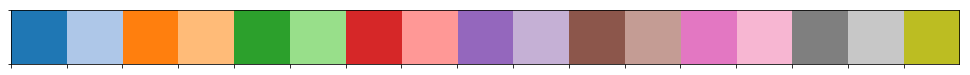

In [122]:
palette = sns.color_palette(palette='tab20', n_colors=len(large_cliques)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(large_cliques)+1))]))

In [123]:
colors = [palette.as_hex()[14]] + sns.color_palette(palette='tab20c', n_colors=len(large_cliques)+1).as_hex()

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


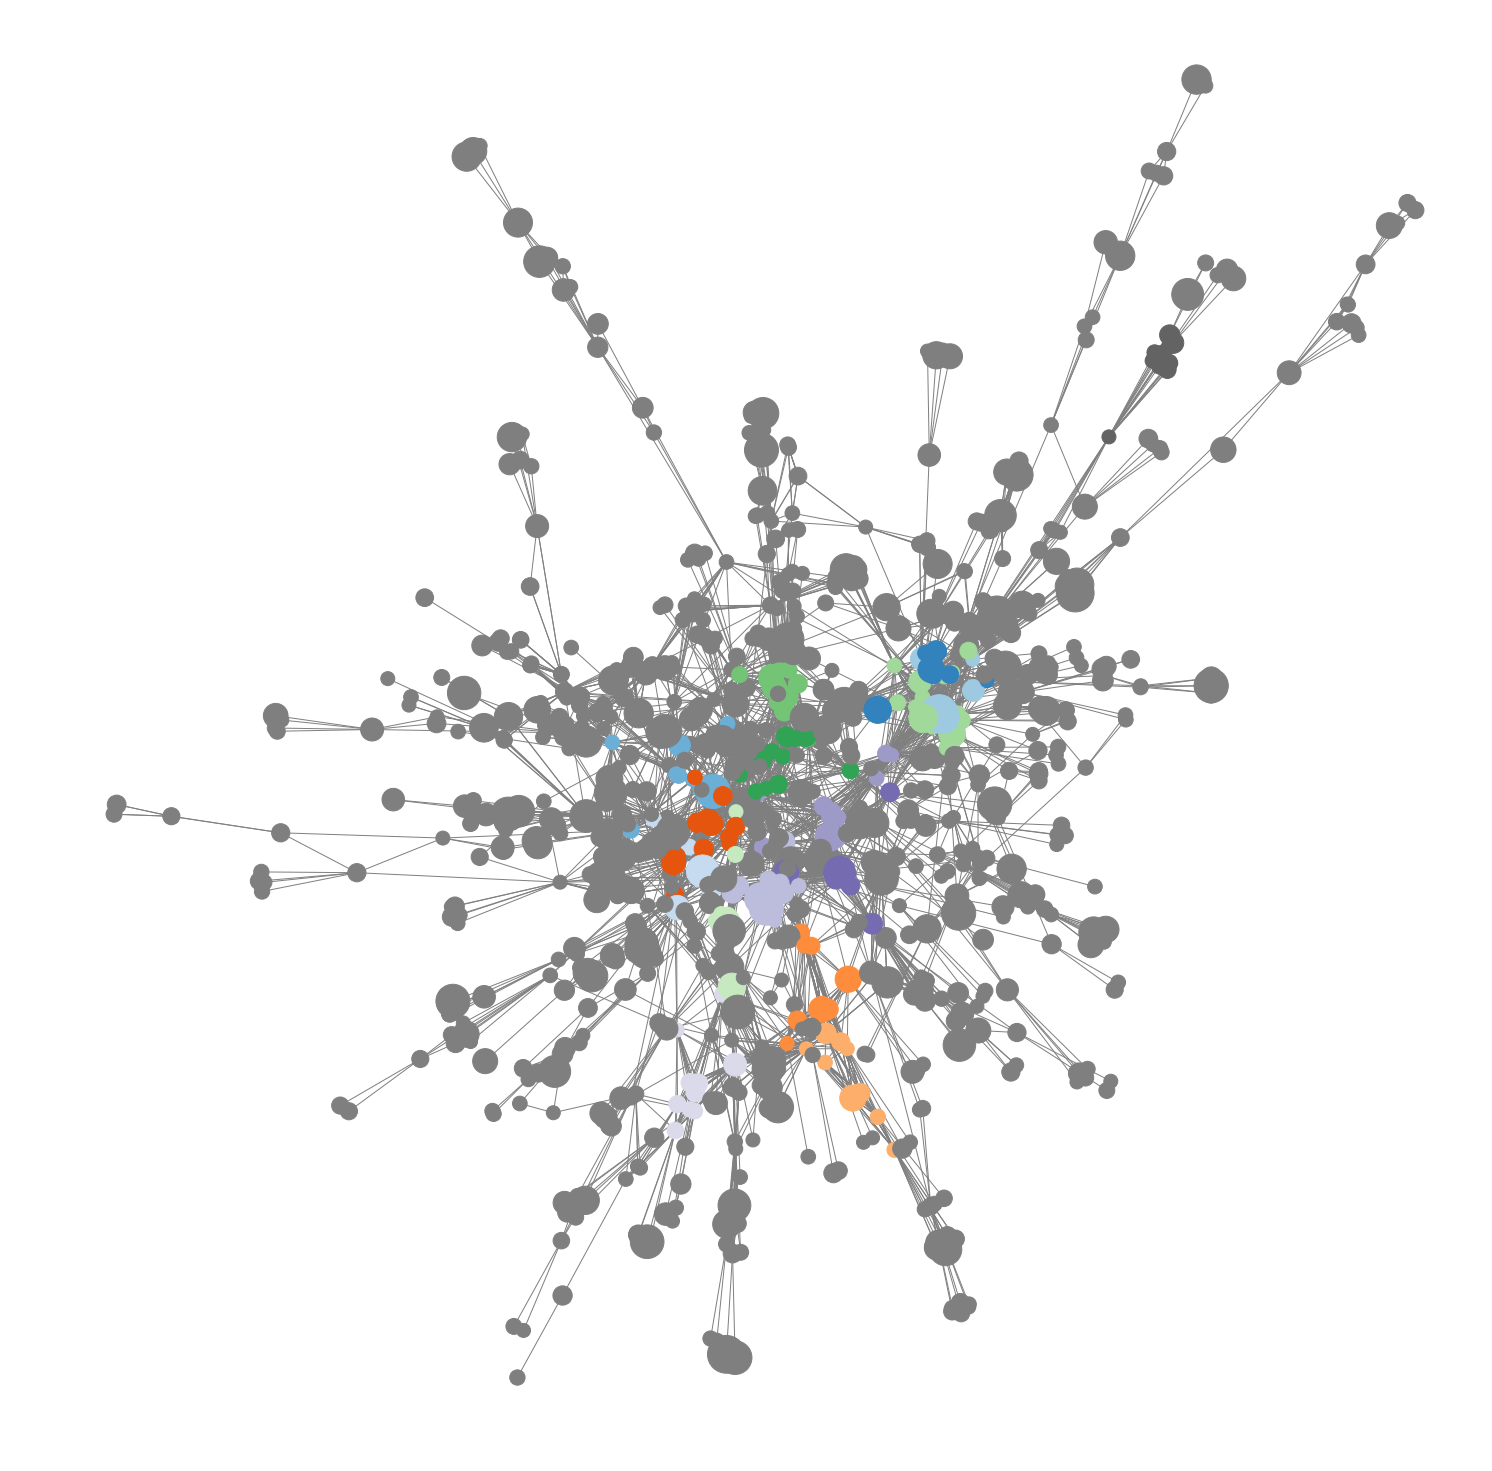

In [124]:
plt.figure(figsize=(20, 20))
nx.draw_spring(main_component, node_color=pd.Series(color_cliques).sort_index().tolist(), 
              cmap=ListedColormap(colors),
              node_size=(node_size+node_size.mean())*6000,
               edge_color='grey',
               iterations=400
              )

In [125]:
nodes[nodes.long_name.isin(['Oshima, Jun', 'de Jong, Frank', 'van Aalst, Jan', 'Chan, Carol', 'Zhang, Jianwei', 'Chen, Mei-Hwa', 'Matsuzawa, Yoshiaki', 'Chen, Bodong', 'Shirouzu, Hajime', 'Scardamalia, Marlene', 'Seitamaa-Hakkarainen, Pirita', 'Laferrière, Thérèse', 'Hakkarainen, Kai', 'Tan, Seng Chee', 'Bereiter, Carl', 'Chai, Shaoming', 'del Castillo, Fernando Diaz', 'McAuley, Alexander', 'Montané, Mireia', 'Reeve, Richard', 'Nunes, Cesar', 'Vinha, Telma', 'Bielaczyc, Katerine', 'Teo, Chew Lee'])]

index                 file  \
94       94  import2015short_146   
97       97  import2015short_185   
98       98  import2015short_185   
154     154  import2016short_167   
282     282  import2015short_192   
289     289        import2018_30   
290     290        import2018_30   
340     340        import2017_61   
401     401    import2016full_81   
460     460        import2018_21   
508     508    import2016full_80   
509     509    import2016full_80   
510     510    import2016full_80   
587     587       import2017_119   
626     626       import2018_375   
741     741       import2018_313   
776     776  import2016short_112   
1365   1365       import2018_257   
1628   1628       import2017_113   
1629   1629       import2017_113   
1630   1630       import2017_113   
1631   1631       import2017_113   
1632   1632       import2017_113   
1633   1633       import2017_113   

                                                   name          domain  \
94                                  Shizuoka University  shizuoka.ac.jp   
97               State University of New York at Albany      albany.edu   
98               State University of New York at Albany      albany.edu   
154   Hiatt Center for Urban Education, Clark Univer...       gmail.com   
282                             University of Hong Kong          hku.hk   
289                              University of Helsinki     helsinki.fi   
290                              University of Helsinki     helsinki.fi   
340                    Ministry of Education, Singapore      moe.gov.sg   
401                                  Queen's University      queensu.ca   
460                             University of Hong Kong          hku.hk   
508                            Aoyama Gakuin University    aoyama.ac.jp   
509               University of Minnesota - Twin Cities         umn.edu   
510                               University of Toronto     utoronto.ca   
587                               University of Toronto     utoronto.ca   
626                                    Tokyo University   u-tokyo.ac.jp   
741                    Nanyang Technological University      ntu.edu.sg   
776                                University of Twente      utwente.nl   
1365                                  McGill University       mcgill.ca   
1628                      South China Normal University         163.com   
1629                                                NaN      glm.edu.co   
1630                 University of Prince Edward Island         upei.ca   
1631                                                NaN          me.com   
1632                             University of Campinas       gmail.com   
1633  Faculty of Education, University of Campinas –...      uol.com.br   

                                         mail  author_order_x        country  \
94                 joshima@inf.shizuoka.ac.jp               0          Japan   
97                         jzhang1@albany.edu               0  United States   
98                           mchen@albany.edu               1  United States   
154                        kateb369@gmail.com              18  United States   
282                           vanaalst@hku.hk               1      Hong Kong   
289   pirita.seitamaa-hakkarainen@helsinki.fi               1        Finland   
290               kai.hakkarainen@helsinki.fi               2        Finland   
340                   TEO_Chew_Lee@moe.gov.sg               2      Singapore   
401                         reever@queensu.ca               1         Canada   
460                           vanaalst@hku.hk               2      Hong Kong   
508                 matsuzawa@si.aoyama.ac.jp               1          Japan   
509                            chenbd@umn.edu               2  United States   
510           marlene.scardamalia@utoronto.ca               3         Canada   
587                 carl.bereiter@utoronto.ca               0         Canada   
626              shirouzu@cor

In [126]:
color = {}
for i, clique in enumerate(large_cliques):
    for member in clique:
        color[member] = i+2

Here we look at these large cliques on a map. We see that while there are global comunities, many are bound to north america. Additonaly, such large collaboration networks do not exist on other continents! 

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


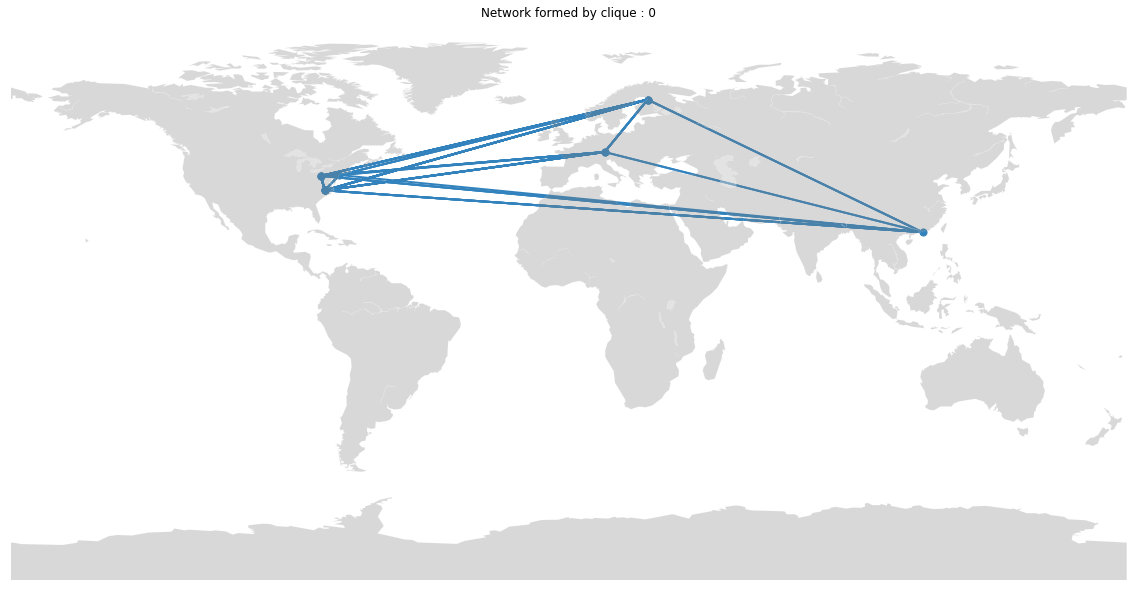

['Fischer, Frank', 'Stegmann, Karsten', 'Mu, Jin', 'Rosé, Carolyn', 'Wen, Miaomiao', 'Malmberg, Jonna', 'Järvenoja, Hanna', 'Yang, Diyi', 'Järvelä, Sanna', 'Wise, Alyssa Friend', 'Azevedo, Roger', 'Mudrick, Nicholas', 'Taub, Michelle', 'Martin, Seth A.', 'Farnsworth, Jesse']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


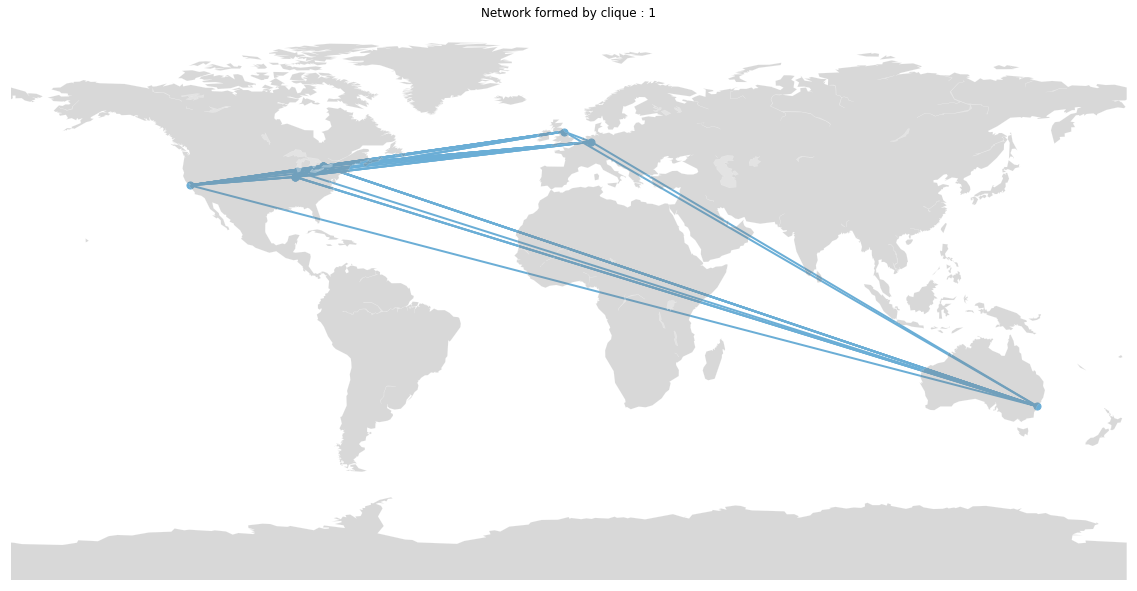

['Cober, Rebecca', 'Moher, Tom', 'Slotta, James D.', 'Fong, Cresencia', 'Israel, Maya', 'Joyce-Gibbons, Andrew', 'Mercier, Emma', 'Shehab, Saadeddine', 'Rummel, Nikol', 'Messina, Richard', 'Peebles, Ben', 'Murray, Julia', 'Martinez-Maldonado, Roberto', 'Forssell, Karin S.']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


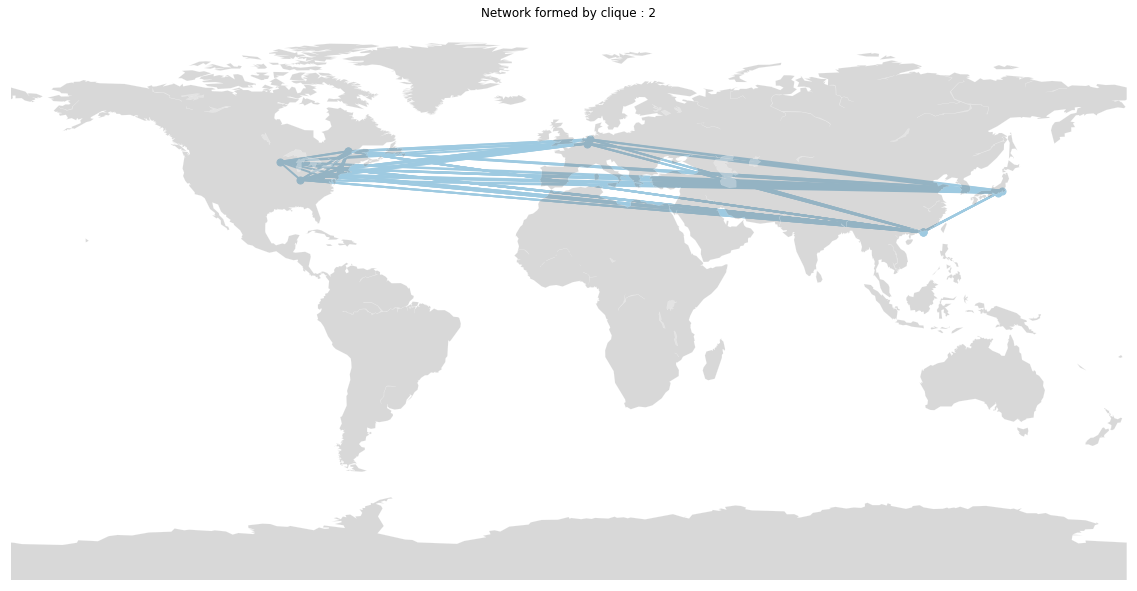

['Wise, Alyssa Friend', 'Rosé, Carolyn', 'de Jong, Frank', 'van Heijst, Hennie', 'Kirschner, Paul', 'Zhang, Jianwei', 'Chen, Feng', 'Chen, Mei-Hwa', 'Godinez, Erick Velazquez', 'Ratté, Sylvie', 'Yang, Christine', 'Silver, Cindy Hmelo', 'Chan, Carol', 'van Aalst, Jan', 'Matsuzawa, Yoshiaki', 'Chen, Bodong', 'Oshima, Jun', 'van den Ende, Joan']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


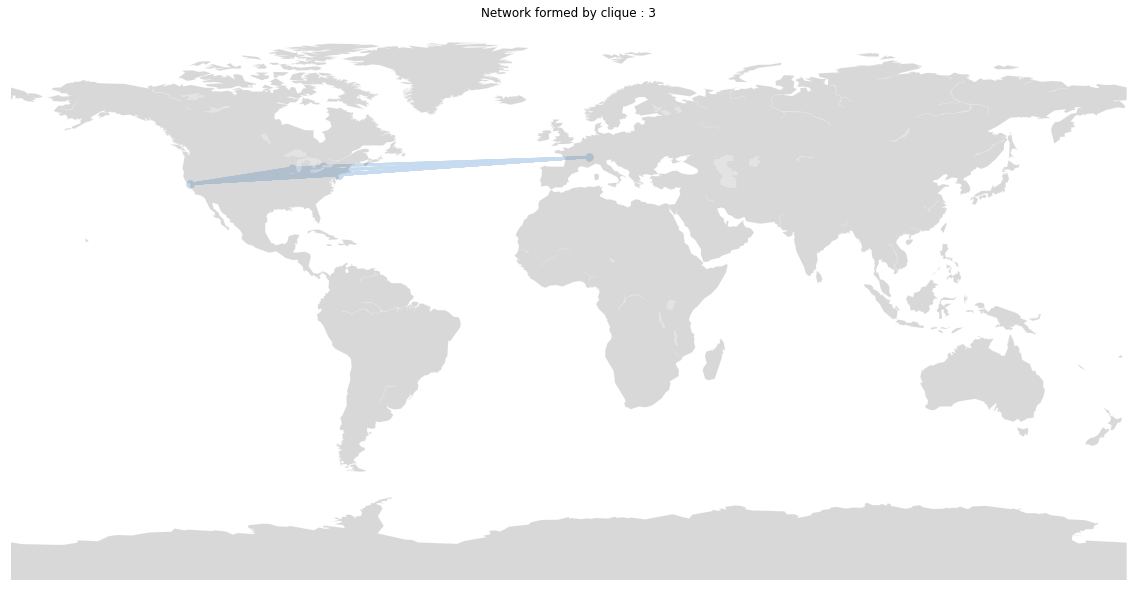

['Schwendimann, Beat A.', 'Tissenbaum, Mike', 'Dillenbourg, Pierre', 'Berland, Matthew', 'Lyons, Leila', 'Cocco, Felipe', 'Plass, Jan L.', 'Hajny, Nik', 'Slotta, James D.', 'Olsen, Al', 'Boroujeni, Mina Shirvani', 'Gerard, Libby', 'Vitale, Jonathan', 'Matuk, Camillia', 'Linn, Marcia']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


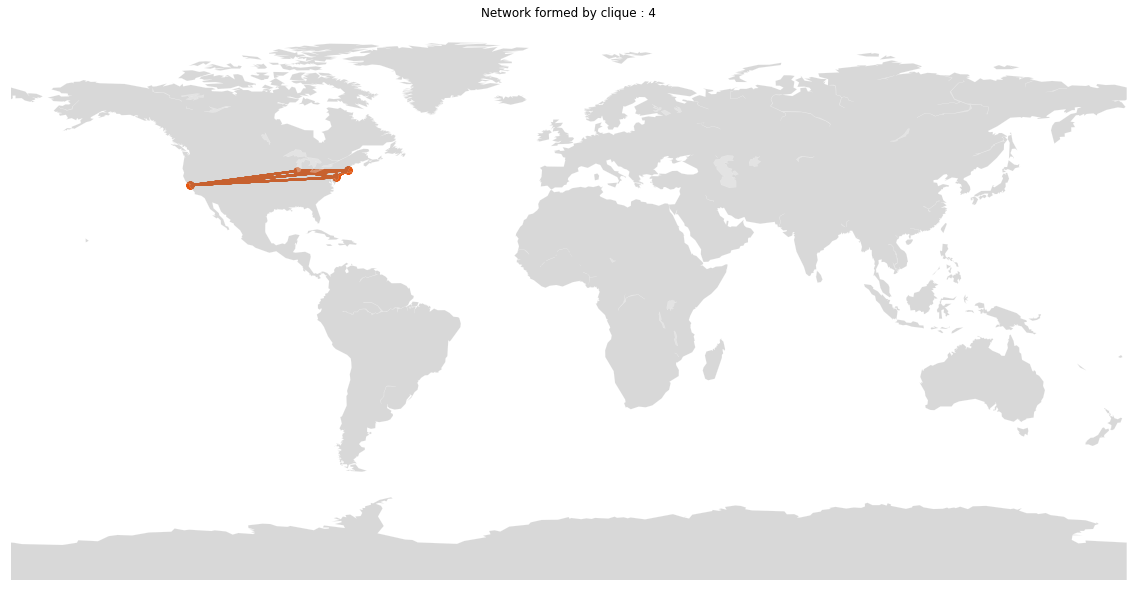

['Shapiro, R. Benjamin', 'Sherman, Mark A', 'Sheldon, Joshua', 'Abelson, Hal', 'Klopfer, Eric', 'Tissenbaum, Mike', 'Grover, Shuchi', 'Horn, Mike', 'Wilensky, Uri', 'Rutstein, Daisy', 'Lui, Debora', 'Snow, Eric', 'Shear, Linda', 'Jayathirtha, Gayithri', 'Lee, Irene', 'Shaw, Mia', 'Mustafaraj, Eni', 'Temple, Will', 'Sorensen, Clara', 'Jona, Kemi', 'Weintrop, David', 'Basu, Satabdi', 'kafai, yasmin']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


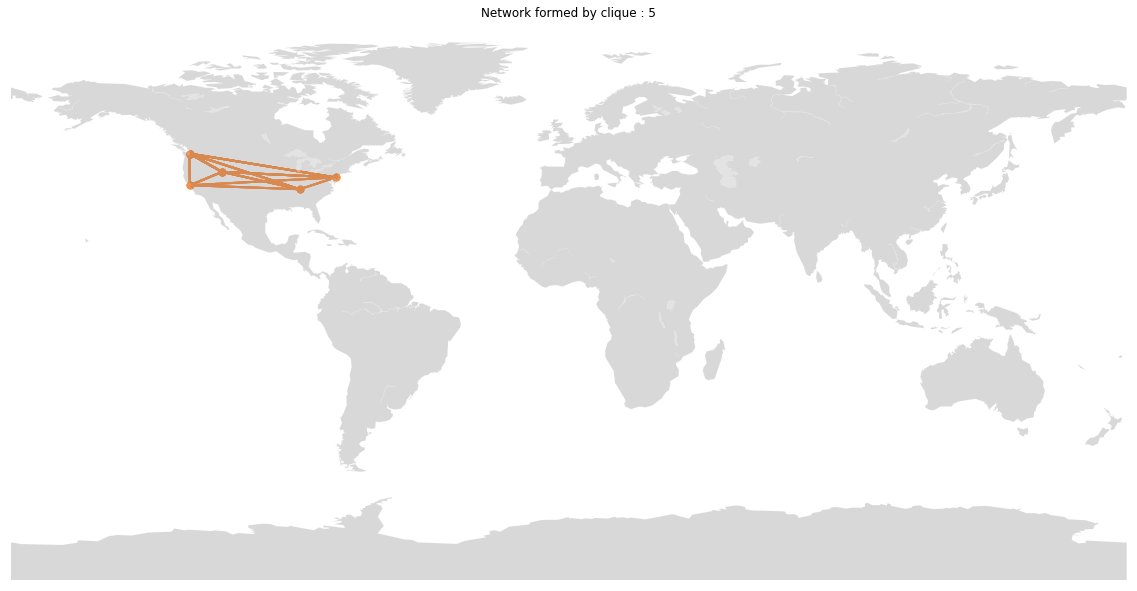

['Lee, Victor', 'Bell, Philip', 'Davis, Richard Lee', 'Hall, Rogers', 'Telhan, Orkan', 'Adleberg, Barrie', 'Kafai, Yasmin B.', 'Bang, Megan', 'Price, Nancy', 'Recker, Mimi', 'Ng, Meixi', 'Stromholt, Shelley', 'Kahn, Jennifer', 'Phillips, Abigail Leigh', 'Hansen, Jennifer', 'Tzou, Carrie', 'Barron, Brigid']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


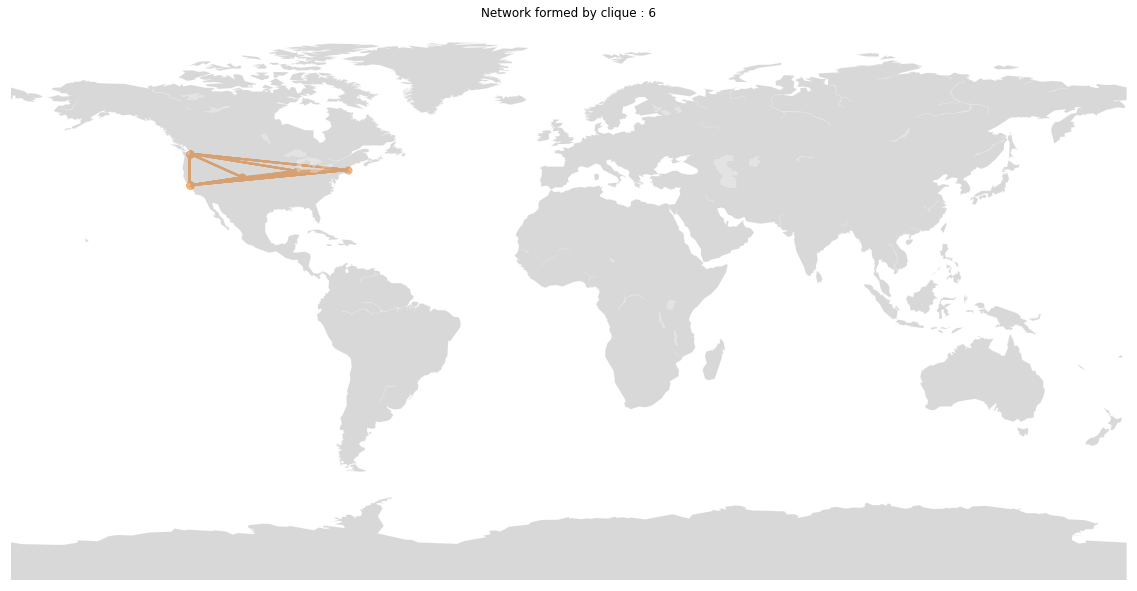

['Bell, Philip', 'Bang, Megan', 'Tzou, Carrie', 'Barron, Brigid', 'Luce, Megan', 'Vea, Tanner', 'Conlin, Luke', 'Martin, Caitlin Kennedy', 'Roque, Ricarose', 'Suárez, Enrique', '*, Meixi', 'Pinkard, Nichole', 'McDermott, Raymond', 'Goldman, Shelley']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


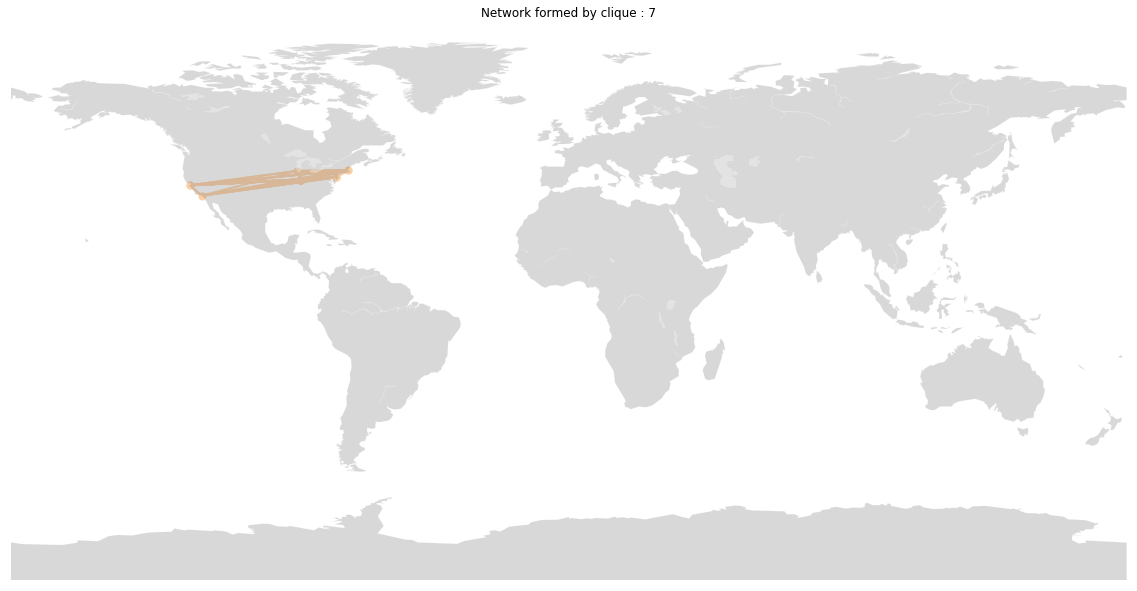

['Georgen, Chris', 'Tu, Xintian', 'Davis, Bria', 'Enyedy, Noel', 'Humburg, Megan', 'Danish, Joshua A.', 'kang, Seokbin', 'Norooz, Leyla', 'Clegg, Tamara', 'Froehlich, Jon E.', 'Horn, Mike', 'kafai, yasmin', 'Walker, Justice Toshiba', 'Washington, Peter', 'Riedel-Kruse, Ingmar', 'Lui, Debora', 'Bumbacher, Engin', 'Blikstein, Paulo', 'Anderson, Emma', 'Byrne, Virginia L']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


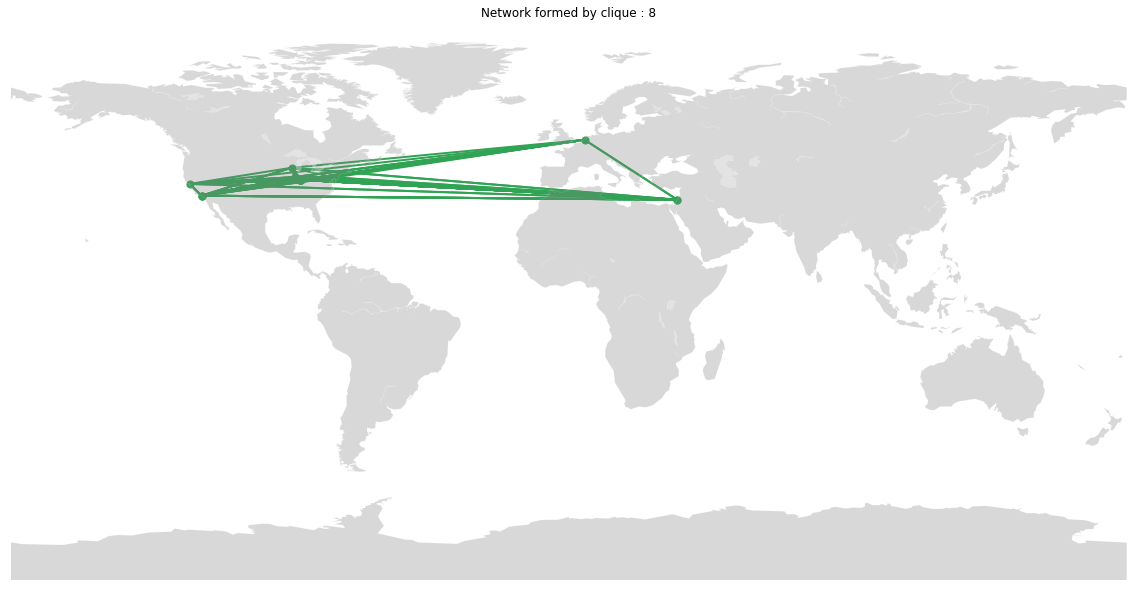

['Georgen, Chris', 'Tu, Xintian', 'Davis, Bria', 'Enyedy, Noel', 'Humburg, Megan', 'Danish, Joshua A.', 'Abrahamson, Dor', 'Dahn, Maggie', 'Lindwall, Oskar', 'Maltese, Adam', 'Andrade, Alejandro', 'Saleh, Asmalina', 'Lee, Christine', 'Brown, David', 'Levy, Sharona T.', 'Nathan, Mitchell', 'Lindgren, Robb', 'Bakker, Arthur', 'Walkington, Candace A', 'Zohar, Asnat R.']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


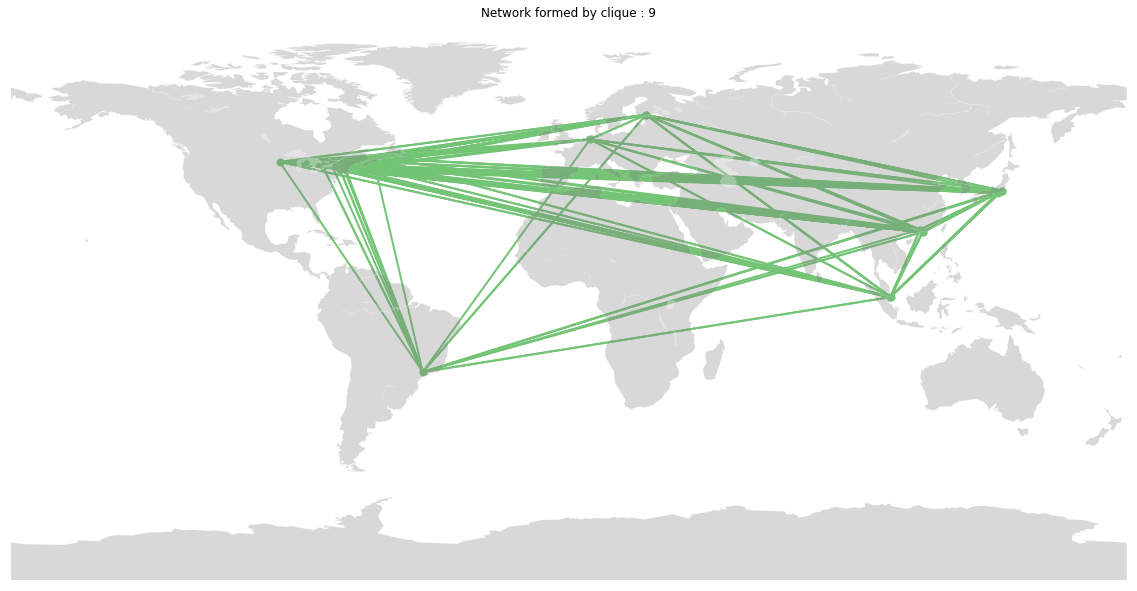

['Oshima, Jun', 'de Jong, Frank', 'van Aalst, Jan', 'Chan, Carol', 'Zhang, Jianwei', 'Chen, Mei-Hwa', 'Matsuzawa, Yoshiaki', 'Chen, Bodong', 'Shirouzu, Hajime', 'Scardamalia, Marlene', 'Nunes, Cesar', 'Seitamaa-Hakkarainen, Pirita', 'Vinha, Telma', 'Hakkarainen, Kai', 'Tan, Seng Chee', 'Bereiter, Carl', 'Reeve, Richard', 'Teo, Chew Lee', 'Laferrière, Thérèse', 'Bielaczyc, Katerine', 'Chai, Shaoming', 'del Castillo, Fernando Diaz', 'McAuley, Alexander', 'Montané, Mireia']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


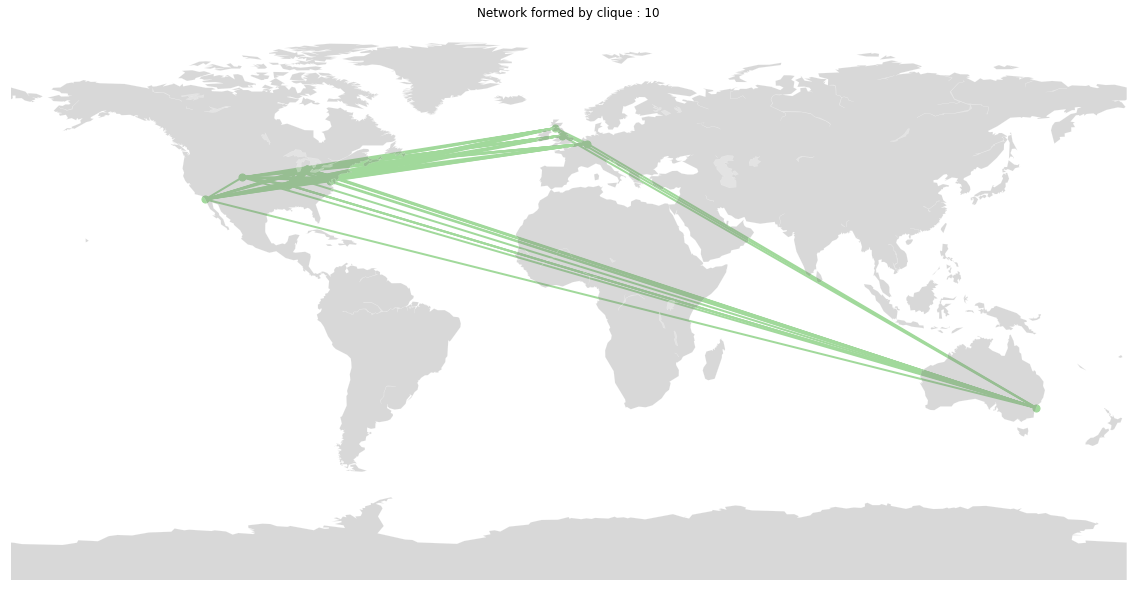

['Yoon, Susan A.', 'Santo, Rafi', 'Anderson, Charles W', 'Baker-Doyle, Kira J', 'van Amersfoort, Daniël', 'de Laat, Maarten', 'Frank, Kenneth A.', 'Hopkins, Megan', 'Lin, Qinyun', 'Marshall, Stefanie Marshall', 'Penuel, Bill', 'Miller, Katie A', 'Nijland, Femke', 'de Freitas, Elizabeth', 'Whitfield, Latricia Chanel Whitfield', 'Shirrell, Matthew', 'Schreurs, Bieke', 'Spillane, James']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


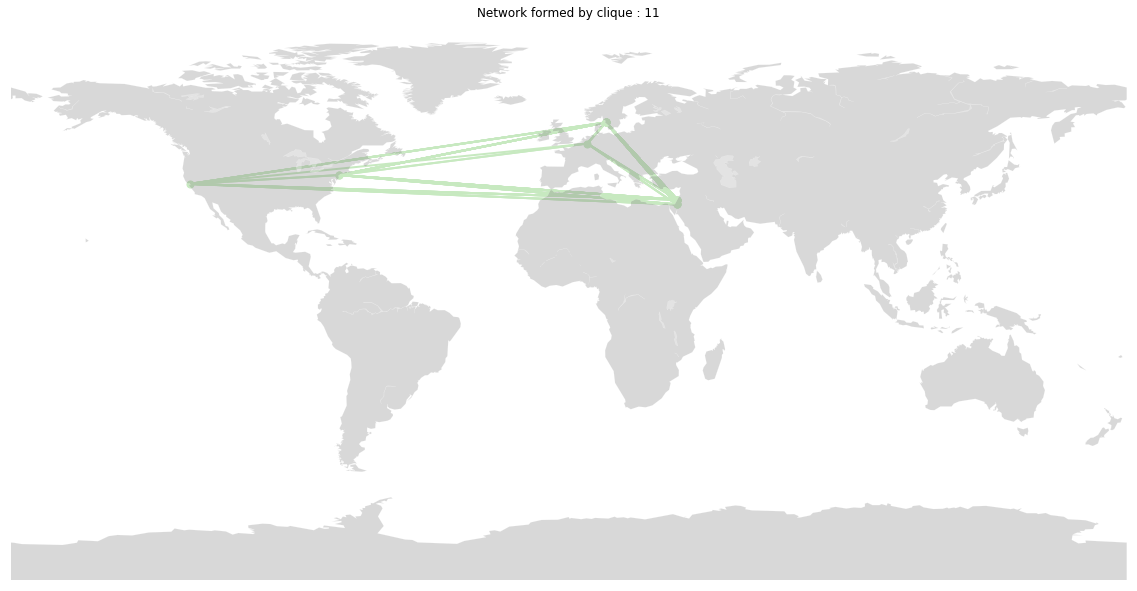

['Kali, Yael', 'Brami, Uzi Zevik', 'Tabak, Iris', 'Kirschner, Paul', 'Barzilai, Sarit', 'Amzalag, Meital', 'Duek, Oshra', 'Elias, Nelly', 'Kent, Carmel', 'Laslo, Esther', 'Levy, Keren S.', 'Rafaeli, Sheizaf', 'Baram-Tsabari, Ayelet', 'Hoadley, Christopher', 'Weiss, Patrice L. Tamar', 'Kidron, Adi', 'Tal, Tali', 'Ben-Zvi, Dani']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


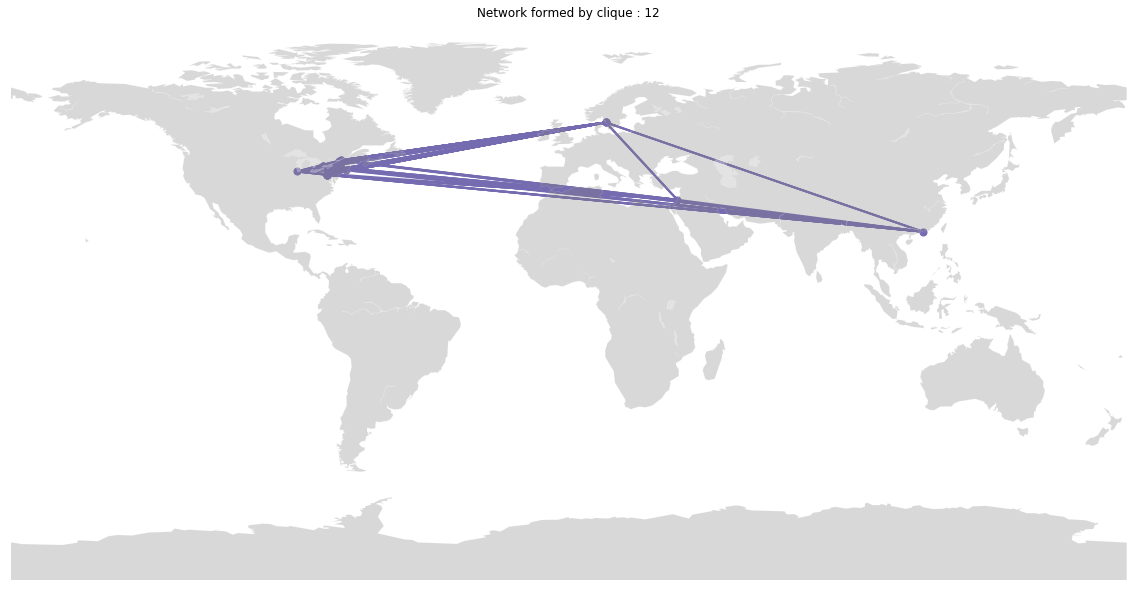

['Kali, Yael', 'Acosta, Alisa', 'Zhang, Jianwei', 'Chen, Mei-Hwa', 'Moher, Tom', 'Slotta, James D.', 'Hod, Yotam', 'Charles, Elizabeth S.', 'Ben-Zvi, Dani', 'Choi, Koun', 'Dugdale, Michael', 'Lenton, Kevin', 'McDonald, Scott', 'Quintana, Rebecca M', 'Rook, Michael M.', 'Tietjen, Phil', 'Weiss, Patrice L. Tamar', 'Whittaker, Chris', 'Bielaczyc, Katerine', 'Kapur, Manu']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


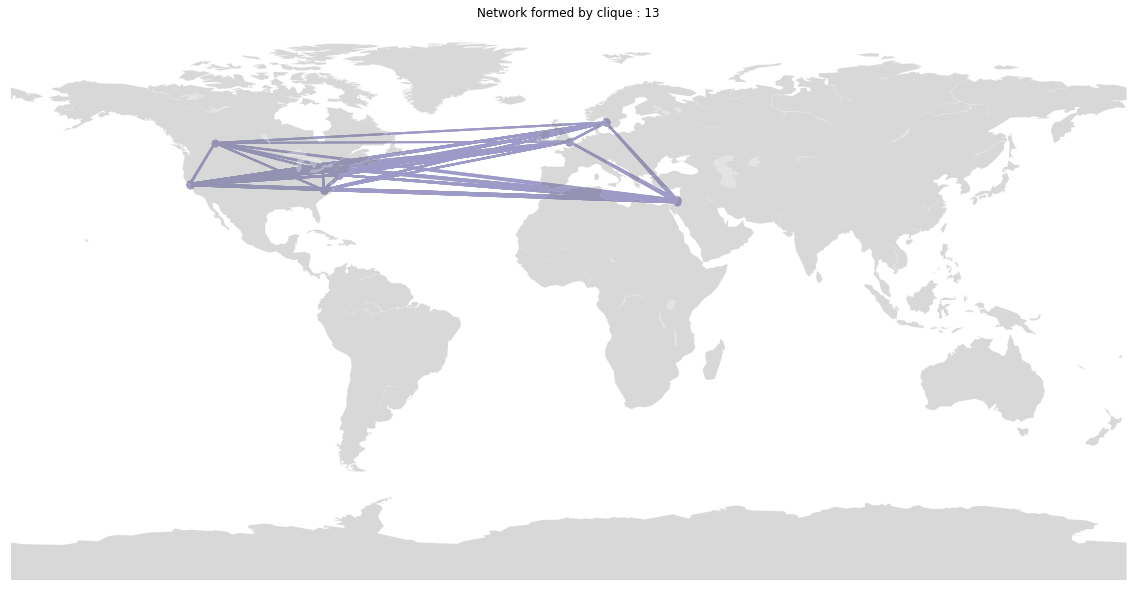

['Kali, Yael', 'Acosta, Alisa', 'Kidron, Adi', 'Tal, Tali', 'Osborne, Jonathan', 'Laurillard, Dianna', 'Slotta, Jim', 'Hovey, Christopher M', 'Ben-Horin, Hava', 'Matuk, Camillia', 'Linn, Marcia', 'Hurwich, Talia A', 'Gerard, Libby', 'Eylon, Bat-Sheva', 'Toutkoushian, Emily', 'Swearingen, Amanda', 'Ryoo, Kihyun “Kelly”', 'Bedell, Kristin Dana Bedell', 'Sagy, Ornit', 'Clark, Doug', 'Virk, Satyugjit', 'Adams, Deanne', 'Sarmiento, Juan Pablo', 'Chiu, Jennifer', 'Bywater, Jim P', 'Hong, James']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


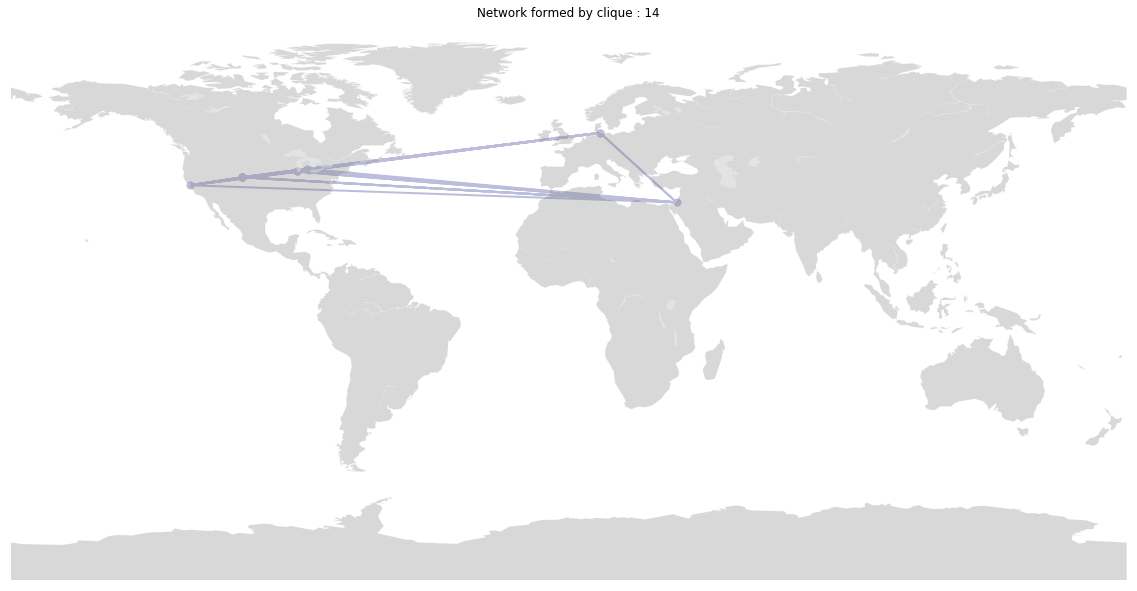

['Pellegrino, James W', 'Gane, Brian Douglas', 'Zaidi, Sania Zahra', 'Pennock, Phyllis Haugabook', 'Briggs, Derek', 'Chattergoon, Rajendra', 'Wingert, Kerri', 'Krajcik, Joe', 'Harris, Christopher J.', 'Furtak, Erin Marie', 'Severance, Sam', 'Penuel, Bill', 'Fortus, David', 'Nordine, Jeffrey', 'Neumann, Knut', 'Van Horne, Katie']


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


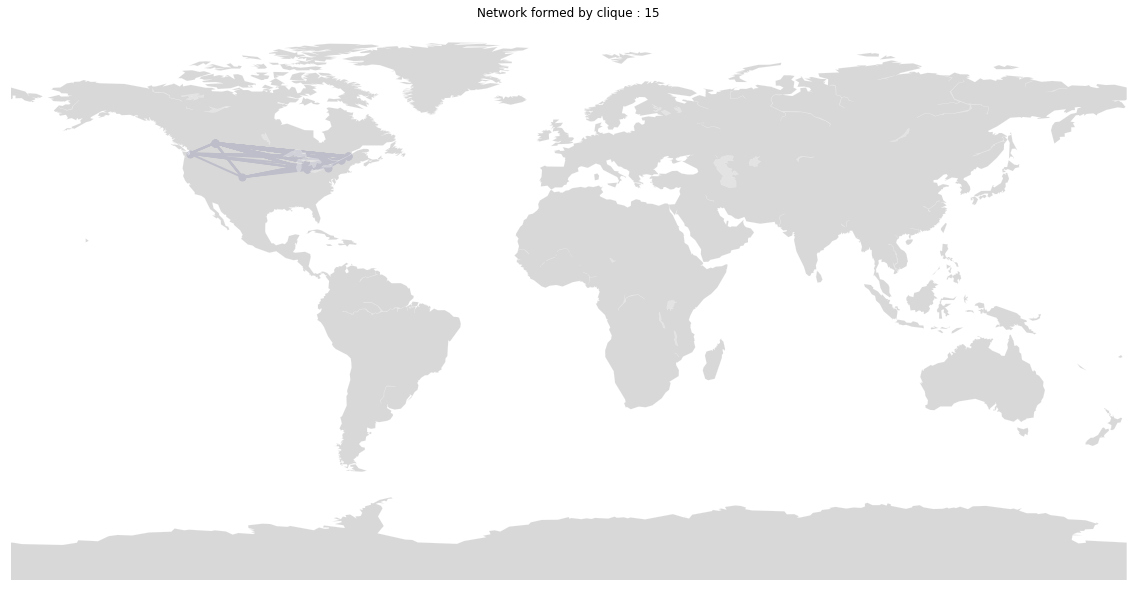

['Barton, Angela Calabrese', 'Adams, Jennifer D', 'Barma, Sylvie', 'Vincent, Marie-Caroline', 'Voyer, Samantha', 'Rahm, Jrene', 'Touioui, Ferdous', 'Shanahan, Marie-Claire', 'Hladik, Stephanie', 'Paré, Dylan', 'Luehmann, April', 'Greenberg, Day', 'Thompson, Jessica', 'Haganah, Sara', "O'Connor, Kevin", 'Sengupta, Pratim']


In [127]:
# prepare a color for each point depending on the continent.
 
# Add a point per position
for i, clique in enumerate(large_cliques):
    plt.figure(figsize=(20, 20))
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    data = nodes.iloc[list(clique)].copy()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= colors[i+1], alpha=1)


    embedding = nodes.iloc[list(clique)].apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(main_component.subgraph(clique),  pos = embedding, 
                           edge_color=colors[i+1], width = 2)
    plt.title('Network formed by clique : {}'.format(i))
    plt.show()
    print(data.long_name.tolist())
    


# Using modularity to identify communities:

In [128]:
mapping = nodes.long_name.to_dict()

c = list(greedy_modularity_communities(main_component))

We change the node size based on degree centrality, the larger the node the more collaborations the individual has:

In [129]:
member_label = matching_by_criteria(c)
nx.set_node_attributes(main_component, member_label, 'community')
node_colors = pd.Series(member_label).sort_index().tolist()
node_size = np.array(list(nx.degree_centrality(main_component).values()))

In [130]:
node_size.mean()

0.009121013467332814

In [131]:
node_size.max()

0.056451612903225805

In [132]:
np.percentile(node_size, 95)

0.026164874551971366

We label the  nodes with the largest centrality:

In [133]:
labels = nodes.iloc[list(largest_cc)]#
labels = labels.iloc[np.where(node_size >= np.percentile(node_size, 99))].long_name.to_dict()

In [134]:
labels

{38: 'Slotta, James D.',
 39: 'Acosta, Alisa',
 97: 'Zhang, Jianwei',
 98: 'Chen, Mei-Hwa',
 146: 'Kali, Yael',
 154: 'Bielaczyc, Katerine',
 179: 'Rummel, Nikol',
 318: 'Rosé, Carolyn',
 319: 'kafai, yasmin',
 460: 'Chan, Carol',
 593: 'Penuel, Bill',
 603: 'Bang, Megan'}

In [135]:
len(labels)

12

   1  ||  2  ||  3  ||  4  ||  5  ||  6  ||  7  ||  8  ||  9  ||  10  ||  11  ||  12  ||  13  ||  14  ||  15  ||  16  ||  17


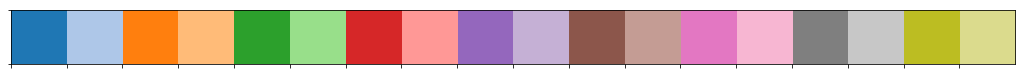

In [136]:
palette = sns.color_palette(palette='tab20', n_colors=len(c)+1)

sns.palplot(palette)
print('  ', '  ||  '.join([str(i) for i in list(range(1,len(c)+1))]))

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


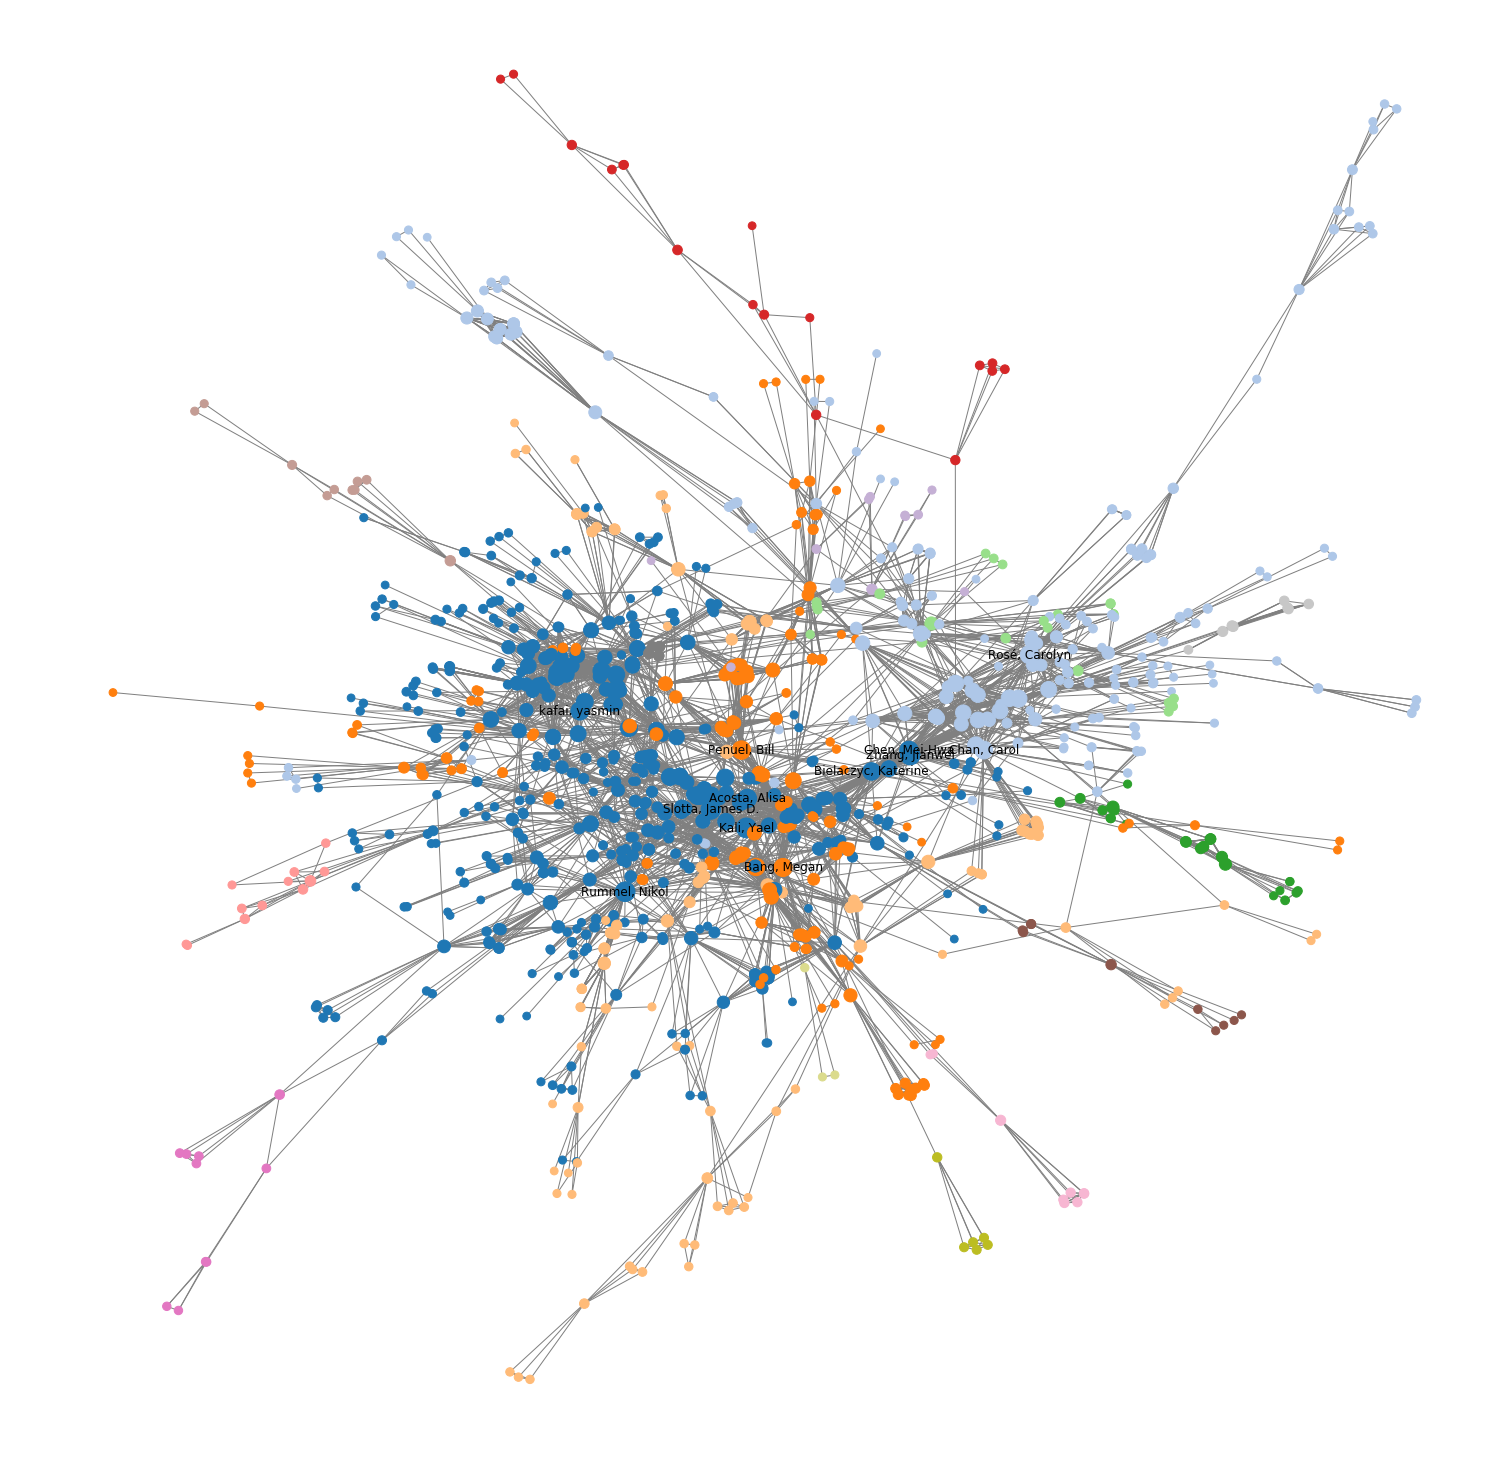

In [137]:
plt.figure(figsize=(20, 20))

nx.draw_spring(main_component, node_color=node_colors, 
                       cmap=ListedColormap(palette.as_hex()),
                       node_size=(node_size+node_size.mean())*6000,
                       labels=labels,
               edge_color='grey',
               iterations=400
              )

Here we have to code that allows to load this graph in Gephi.

In [138]:
nx.set_node_attributes(main_component, nodes.country.to_dict(), name='country')
nx.set_node_attributes(main_component, nodes.name.to_dict(), name='uni')
nx.set_node_attributes(main_component, nx.degree_centrality(graph), name='centrality')

#mapping = nodes.long_name.to_dict()
#main_component_names =nx.relabel_nodes(main_component,mapping)
#nx.write_gexf(H, 'data/main_coauthor_graph.gexf')
#nx.write_gpickle(main_component_names, 'data/coauthor_graph')

### Analyzing each subcomponent

We look at distribution of country and inst. inside these clusters (my it's associated members):

In [139]:
c = [x for x in c if len(x) > 20]

Cluster dist for cluster 1


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


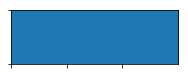

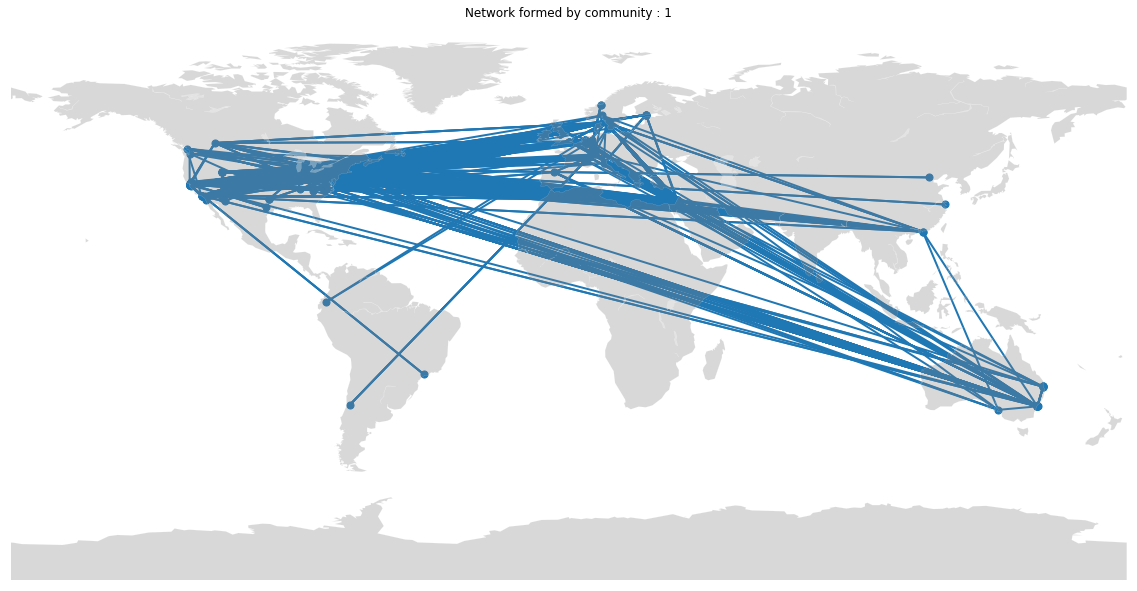

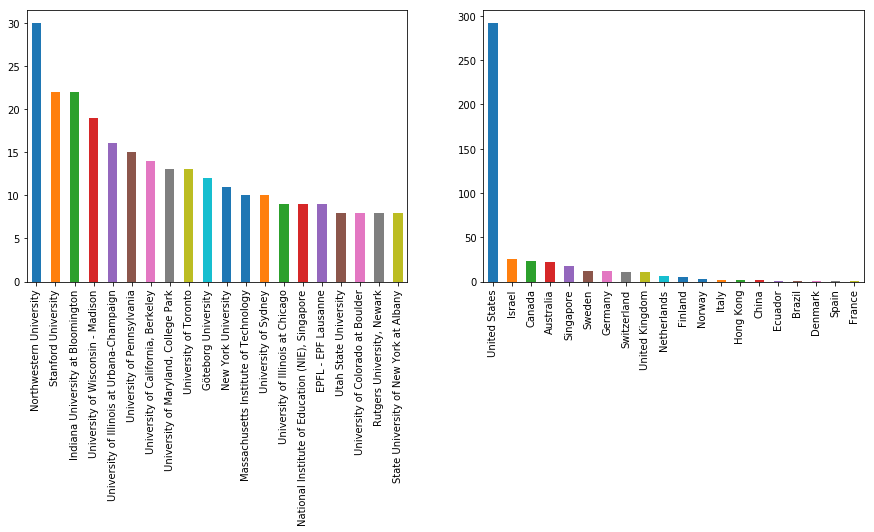

Number of countries in cluster:  22
Number of institutions in cluster:  99
Number of people in cluster:  452


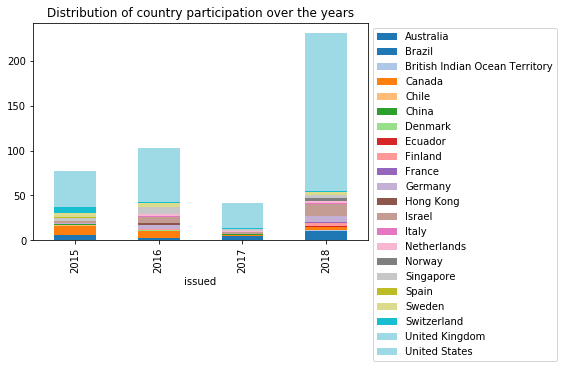

Cluster dist for cluster 2


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


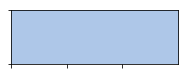

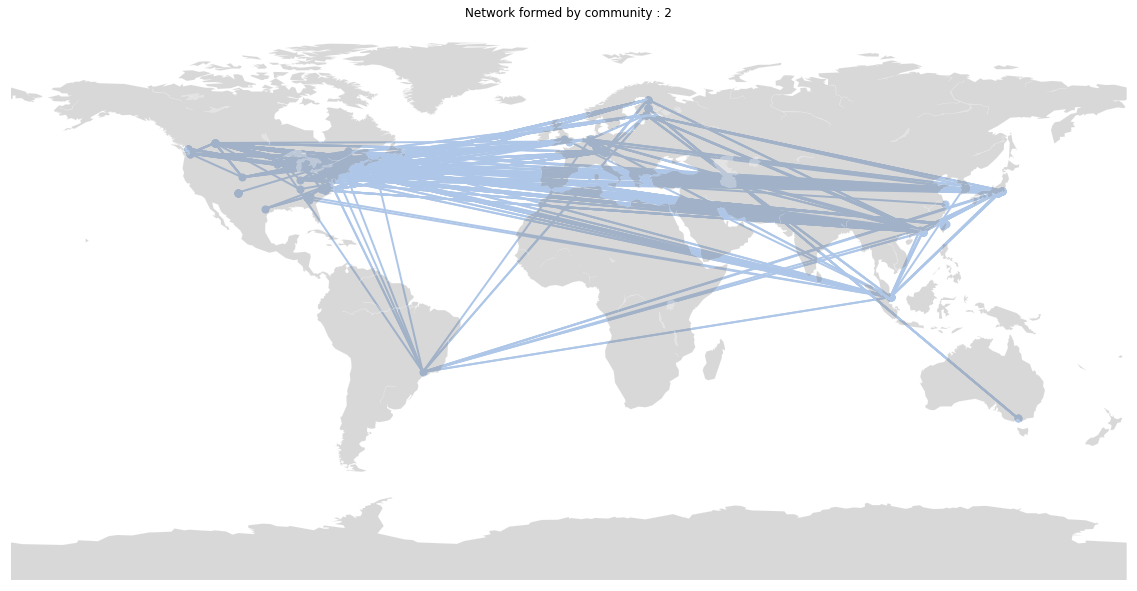

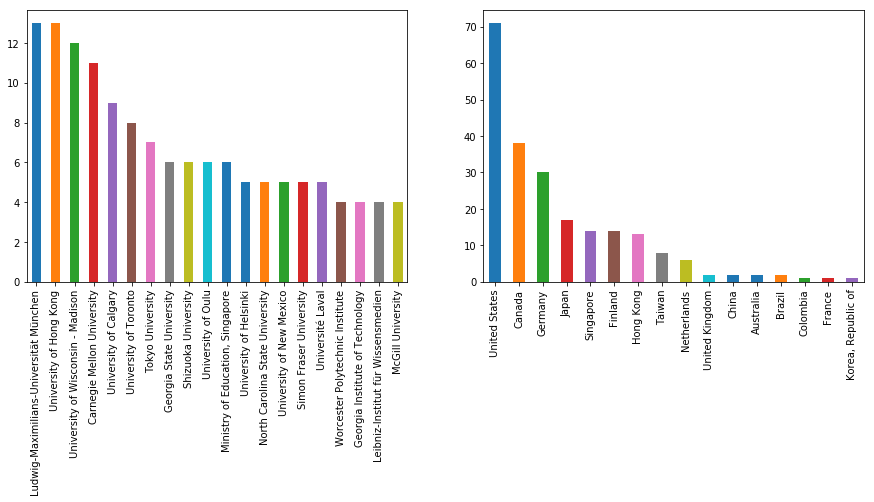

Number of countries in cluster:  16
Number of institutions in cluster:  73
Number of people in cluster:  222


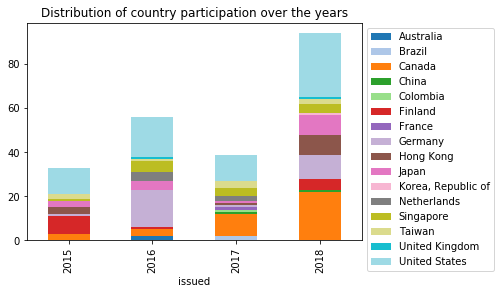

Cluster dist for cluster 3


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


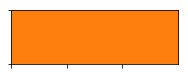

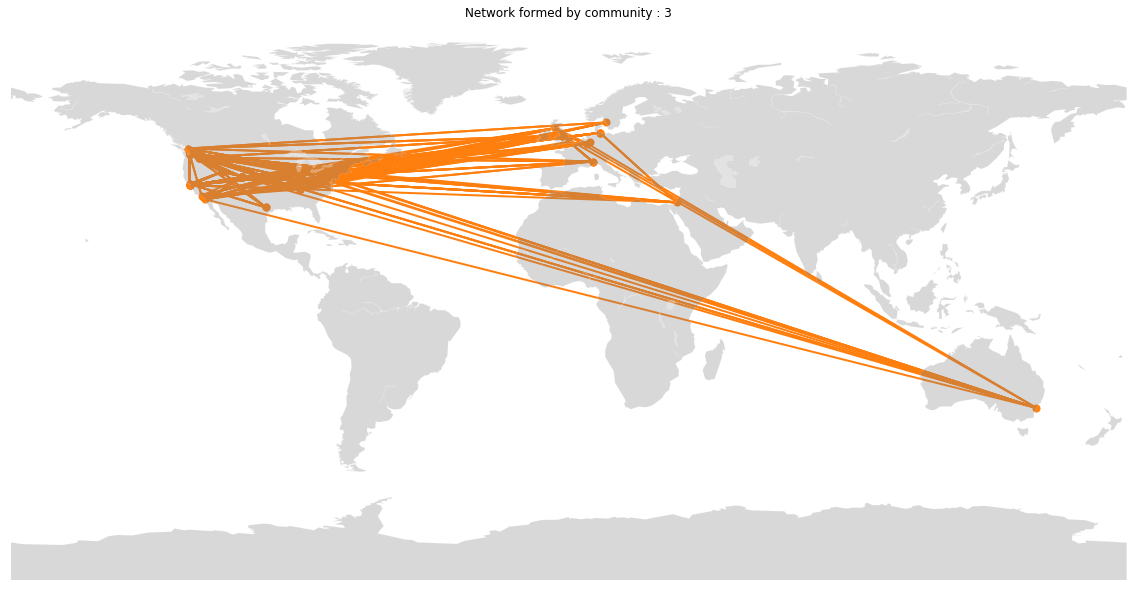

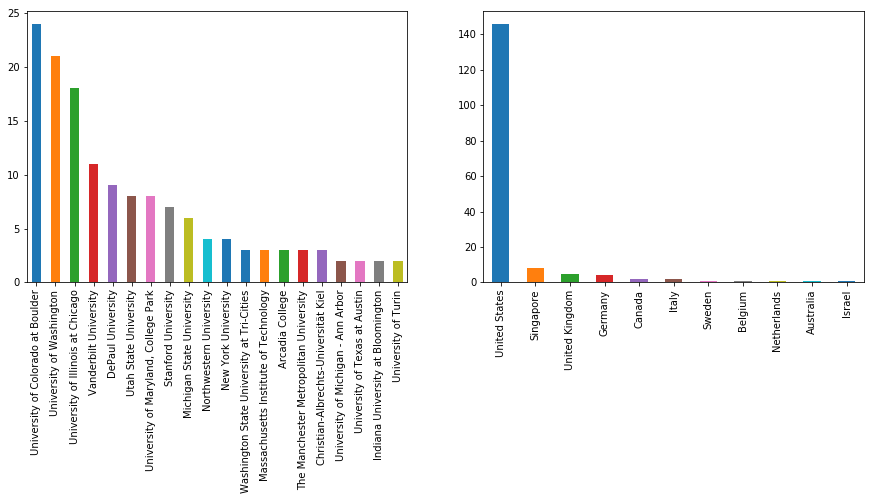

Number of countries in cluster:  11
Number of institutions in cluster:  40
Number of people in cluster:  172


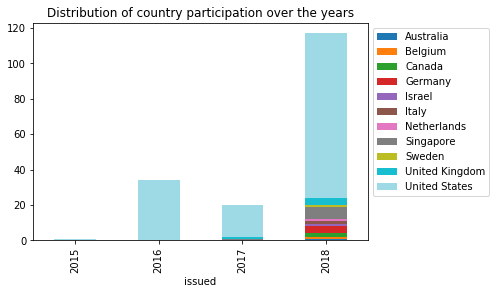

Cluster dist for cluster 4


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


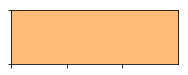

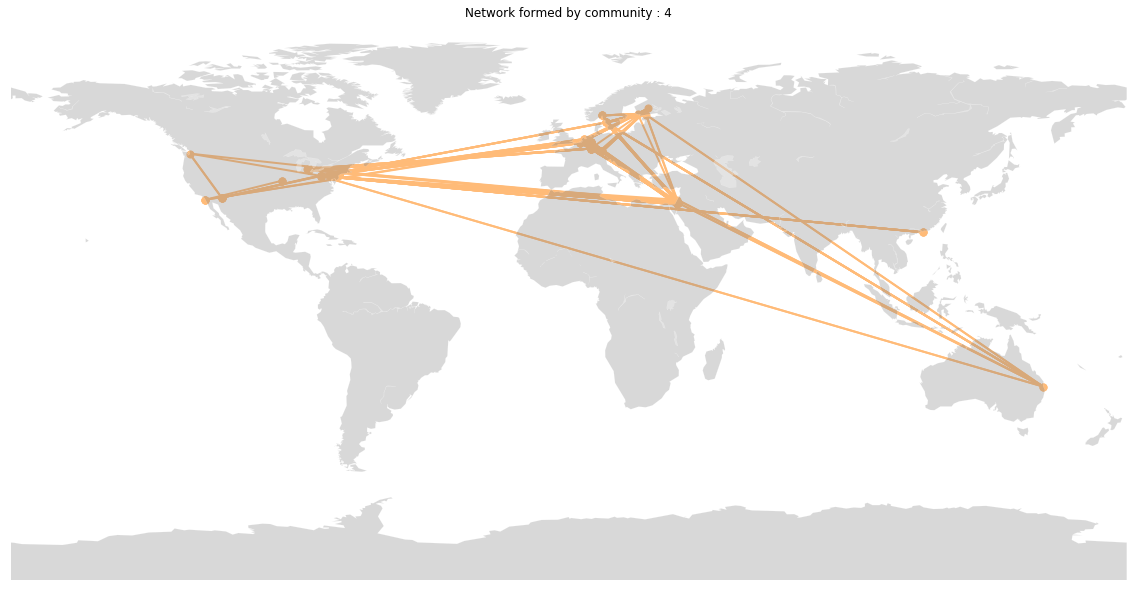

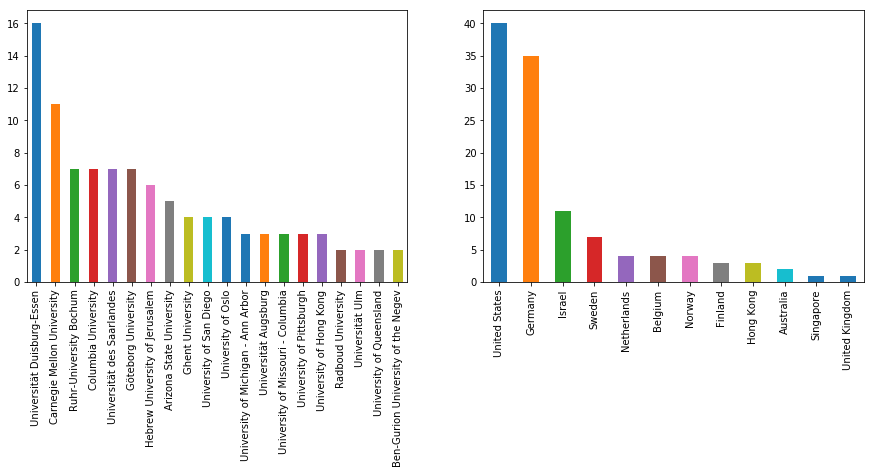

Number of countries in cluster:  12
Number of institutions in cluster:  32
Number of people in cluster:  115


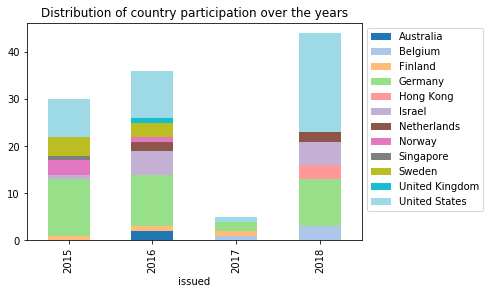

Cluster dist for cluster 5


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


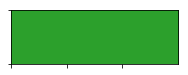

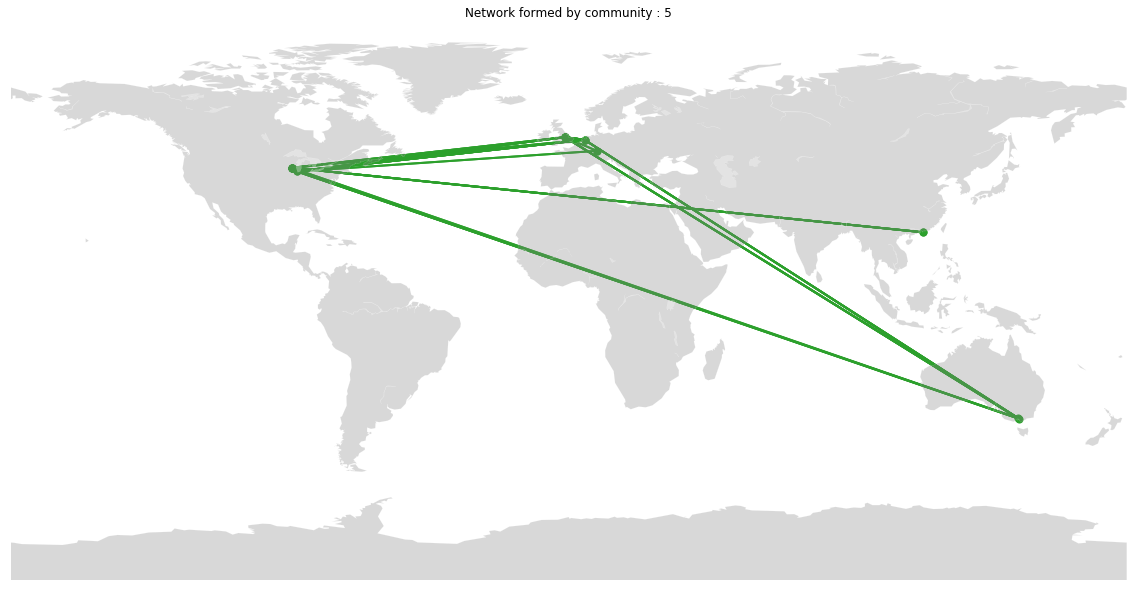

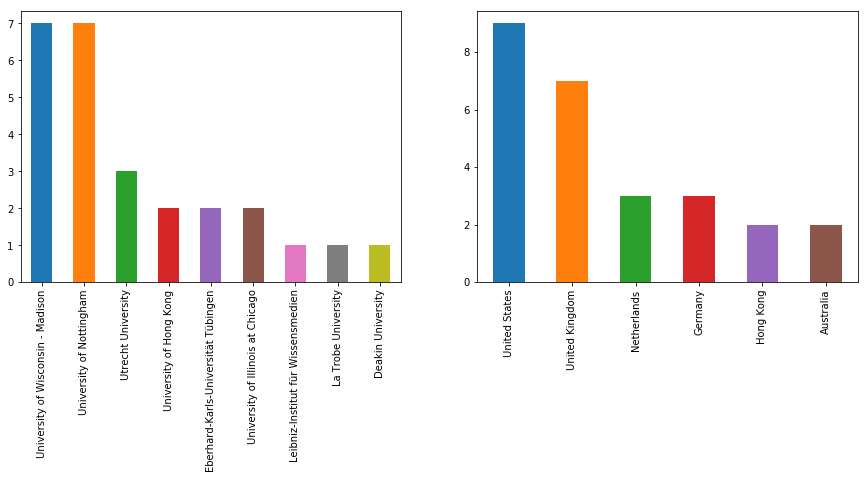

Number of countries in cluster:  6
Number of institutions in cluster:  9
Number of people in cluster:  26


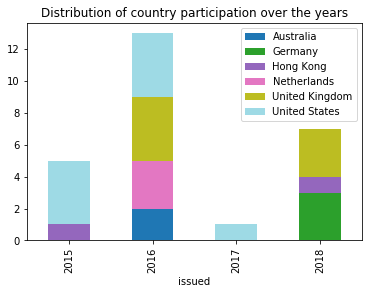

Cluster dist for cluster 6


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


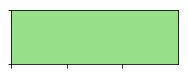

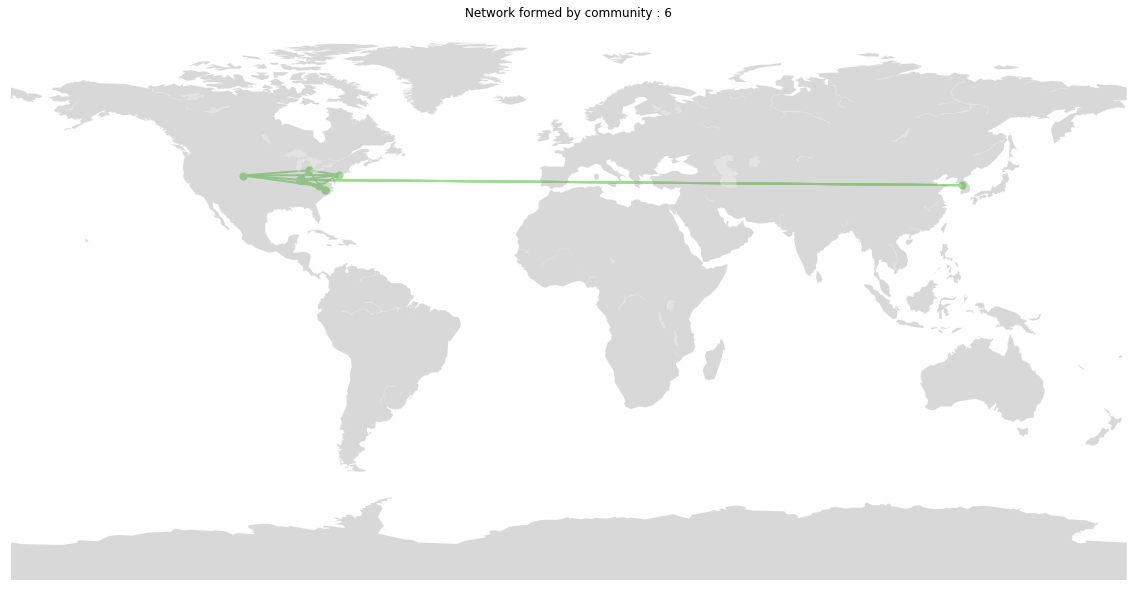

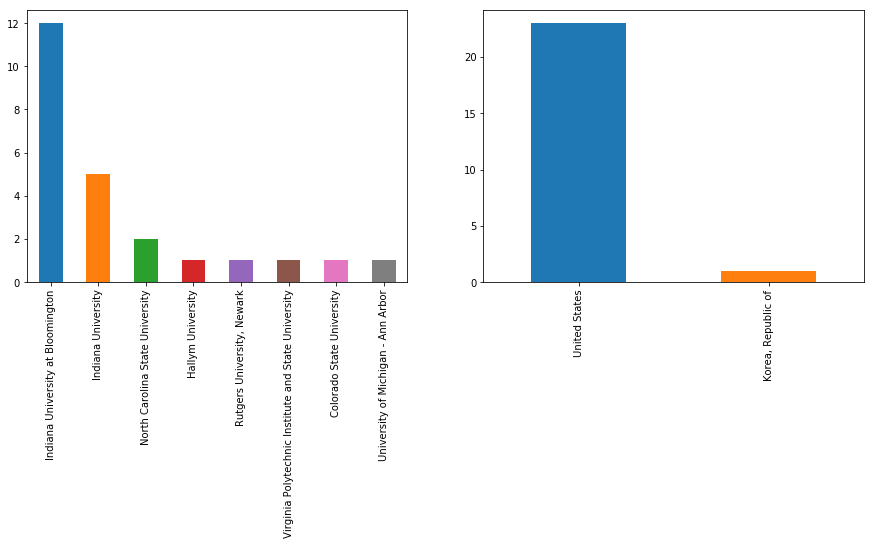

Number of countries in cluster:  2
Number of institutions in cluster:  8
Number of people in cluster:  24


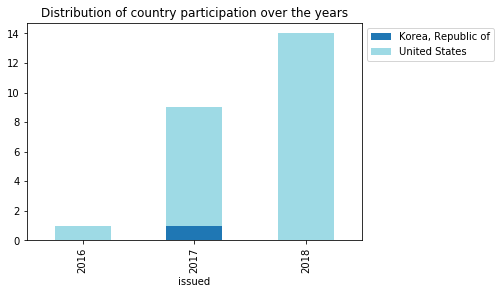

In [140]:
for i,cluster in enumerate(c):
    print(f'Cluster dist for cluster {i+1}')
    sns.palplot(palette[i])
    
    plt.figure(figsize=(20, 20))
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    data = nodes.iloc[list(cluster)].copy()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= palette.as_hex()[i], alpha=1)


    embedding = nodes.iloc[list(cluster)].apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(main_component.subgraph(cluster),  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 2)
    plt.title('Network formed by community : {}'.format(i+1))
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    nodes.iloc[list(cluster)].name.value_counts().head(20).plot('bar')
    plt.subplot(122)
    nodes.iloc[list(cluster)].country.value_counts().head(20).plot('bar')
    plt.show()
    print('Number of countries in cluster: ', len(nodes.iloc[list(cluster)].country.unique()))
    print('Number of institutions in cluster: ', len(nodes.iloc[list(cluster)].name.unique()))
    print('Number of people in cluster: ', len(nodes.iloc[list(cluster)].long_name.unique()))
    
    #plt.title('Number of people submitting over the years over the years')
    
   
    plot_df = pd.DataFrame(nodes.iloc[list(cluster)].groupby(['issued'])\
                           .country.value_counts()).rename(columns={'country':'count'}).reset_index()
    plot_df.pivot(index='issued', columns='country', values='count').plot(kind='bar', stacked=True, colormap=plt.cm.tab20)
    plt.title('Distribution of country participation over the years')
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.show()    
    


## An other way to partition the graph: Hierarchical clustering

NOT DONE YET

## Looking at people moving around

We now look at people who moved from one country to an other within the period of the papers in the parsed papers:

We have to look at years as well to avoid duplicates, however, this could be due to people being associated to multiple institutions at once.

In [141]:
name_country = associations[['name', 'mail', 'country', 'long_name', 'shortend_names','issued']]

In [142]:
#Add year to see
df = pd.merge(name_country, name_country, on='long_name').dropna()
df = df[df.country_x != df.country_y]
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.country_x, x.country_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df[~df[['long_name', 'set_countries']].duplicated()].head()

name_x                    mail_x country_x  \
609  University of Toronto    jim.slotta@utoronto.ca    Canada   
619  University of Toronto    jim.slotta@utoronto.ca    Canada   
707  University of Toronto  alisa.acosta@utoronto.ca    Canada   
713  University of Toronto  alisa.acosta@utoronto.ca    Canada   
719  University of Toronto  alisa.acosta@utoronto.ca    Canada   

            long_name shortend_names_x  issued_x               name_y  \
609  Slotta, James D.     Slotta J. D.      2015       Boston College   
619  Slotta, James D.          Kali Y.      2016       Boston College   
707     Acosta, Alisa     Slotta J. D.      2015  New York University   
713     Acosta, Alisa    Charles E. S.      2016  New York University   
719     Acosta, Alisa        Acosta A.      2018  New York University   

             mail_y      country_y shortend_names_y  issued_y  \
609   slotta@bc.edu  United States         Moher T.      2017   
619   slotta@bc.edu  United States         Moher T.      2017   
707  th1425@nyu.edu  United States            Clark      2018   
713  th1425@nyu.edu  United States            Clark      2018   
719  th1425@nyu.edu  United States            Clark      2018   

                   set_countries  
609  20152017CanadaUnited States  
619  20162017CanadaUnited States  
707  20152018CanadaUnited States  
713  20162018CanadaUnited States  
719  20182018CanadaUnited States

In [143]:
df = pd.merge(name_country, name_country, on='long_name').dropna()
df['set_countries'] = df.apply(lambda x: ''.join(sorted([x.name_x, x.name_y, str(x.issued_x), str(x.issued_y)])), axis=1)
df = df[~df[['long_name', 'set_countries']].duplicated()]
df[(df.name_x != df.name_y) & (df.country_x != df.country_y)][['long_name','shortend_names_y', 'name_x', 'name_y', 'issued_x', 'issued_y']].head(3)

long_name shortend_names_y  \
609  Slotta, James D.         Moher T.   
619  Slotta, James D.         Moher T.   
639  Slotta, James D.         Moher T.   

                                                name_x          name_y  \
609                              University of Toronto  Boston College   
619                              University of Toronto  Boston College   
639  Ontario Institute for Studies in Education, Un...  Boston College   

     issued_x  issued_y  
609      2015      2017  
619      2016      2017  
639      2016      2017

Number of people that changed organisation:

#TODO fix years

In [144]:
df[(df.name_x != df.name_y) & (df.country_x == df.country_y)].drop_duplicates().head()

name_x                            mail_x  \
100  Indiana University at Bloomington               agomoll90@gmail.com   
104  Indiana University at Bloomington               agomoll@indiana.edu   
243           Georgia State University               lmargulieux@gsu.edu   
245           Georgia State University               lmargulieux@gsu.edu   
285               Universität Augsburg  ingo.kollar@phil.uni-augsburg.de   

         country_x              long_name  shortend_names_x  issued_x  \
100  United States   Gomoll, Andrea Sarah      Gomoll A. S.      2018   
104  United States   Gomoll, Andrea Sarah      Gomoll A. S.      2016   
243  United States  Margulieux, Lauren E.  Margulieux L. E.      2018   
245  United States  Margulieux, Lauren E.  Margulieux L. E.      2018   
285        Germany           Kollar, Ingo         Kollar I.      2016   

                                     name_y                  mail_y  \
100                      Indiana University          agomoll@iu.edu   
104                      Indiana University          agomoll@iu.edu   
243         Georgia Institute of Technology       l.marg@gatech.edu   
245         Georgia Institute of Technology       l.marg@gatech.edu   
285  Ludwig-Maximilians-Universität München  ingo.kollar@psy.lmu.de   

         country_y  shortend_names_y  issued_y  \
100  United States      Gomoll A. S.      2018   
104  United States      Gomoll A. S.      2018   
243  United States  Margulieux L. E.      2015   
245  United States  Margulieux L. E.      2016   
285        Germany         Kollar I.      2015   

                                         set_countries  
100  20182018Indiana UniversityIndiana University a...  
104  20162018Indiana UniversityIndiana University a...  
243  20152018Georgia Institute of TechnologyGeorgia...  
245  20162018Georgia Institute of TechnologyGeorgia...  
285  20152016Ludwig-Maximilians-Universität München...

## Looking at the network over the years

One interessting observation is that the ICLS years are much more dense and connected.

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


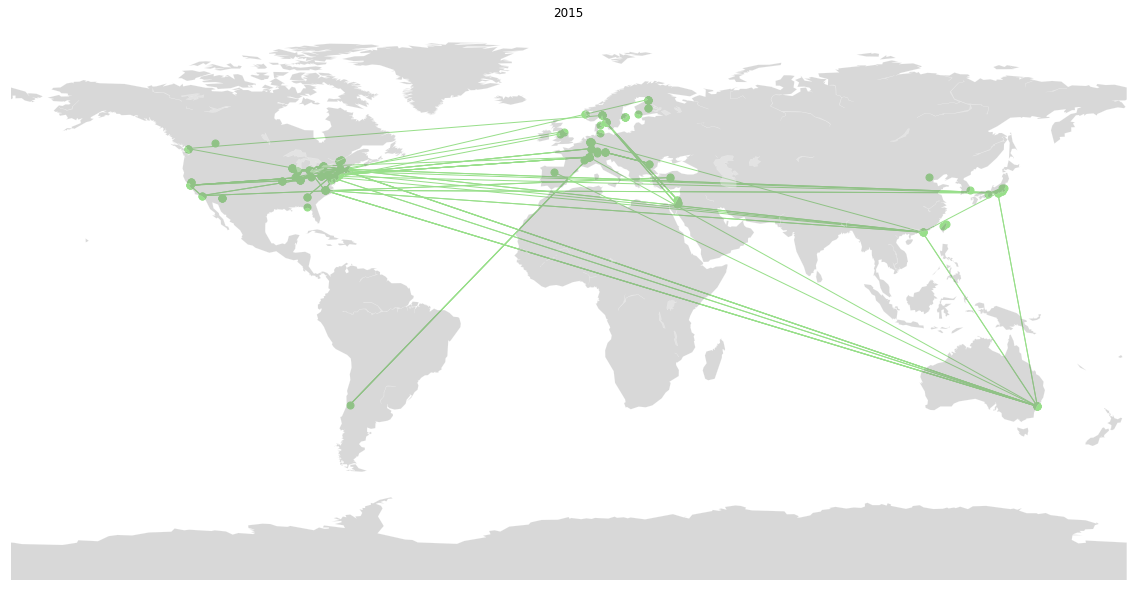

Density of the graph :  0.015628699976320153
The largest component has  62 nodes accounting for 30.10 % of the nodes
The diameter of the largest component is 10
Attribute Assortativity coef: Country:  0.5625722949948418
Attribute Assortativity coef: Uni:  0.43996471614715665


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


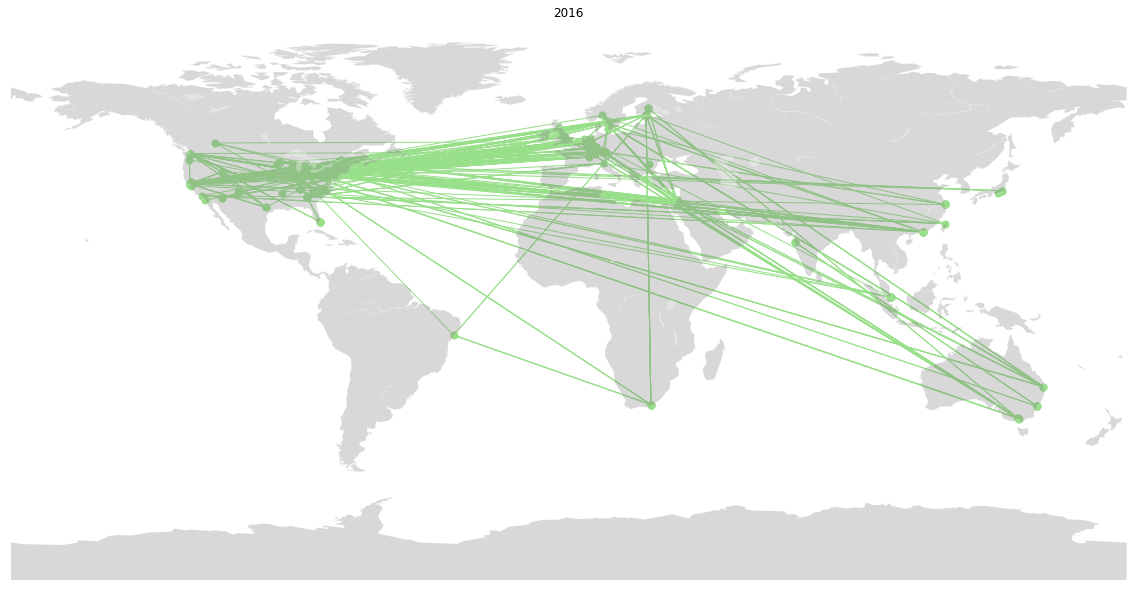

Density of the graph :  0.012578060563214328
The largest component has  177 nodes accounting for 47.97 % of the nodes
The diameter of the largest component is 11
Attribute Assortativity coef: Country:  0.3580732433330397
Attribute Assortativity coef: Uni:  0.2881070032069019


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


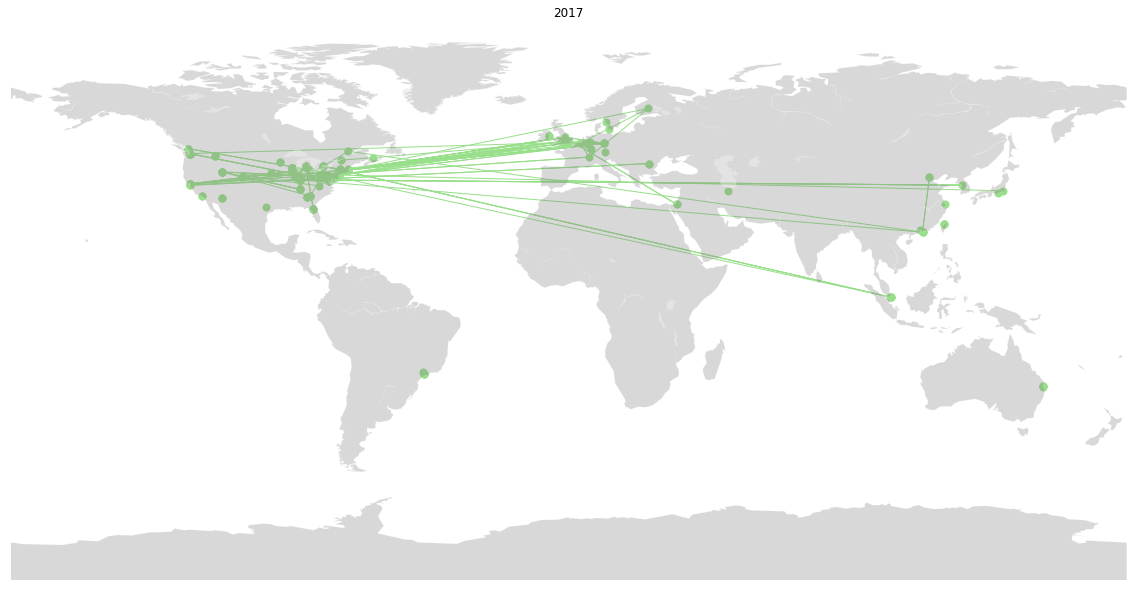

Density of the graph :  0.009434330045612256
The largest component has  16 nodes accounting for 7.05 % of the nodes
The diameter of the largest component is 3
Attribute Assortativity coef: Country:  0.48346982808621214
Attribute Assortativity coef: Uni:  0.43052274918831884


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


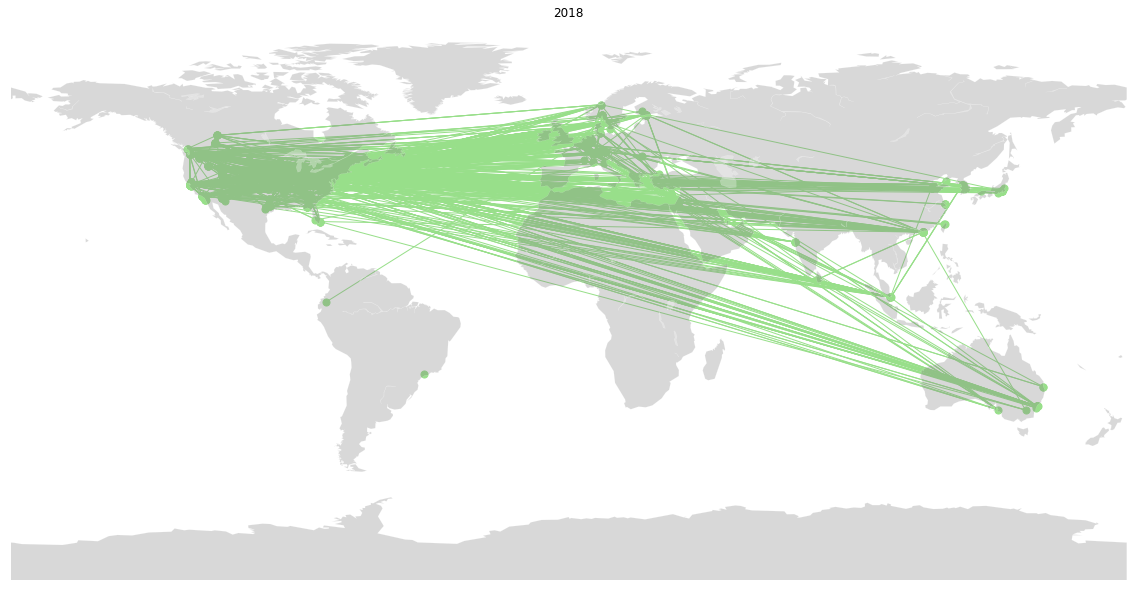

Density of the graph :  0.004930051116491794
The largest component has  368 nodes accounting for 38.94 % of the nodes
The diameter of the largest component is 18
Attribute Assortativity coef: Country:  0.4641611388454498
Attribute Assortativity coef: Uni:  0.34646119777172824


In [145]:
for year in sorted(nodes.issued.unique()):

    plt.figure(figsize=(20, 20))
    plt.title(year)
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    data = nodes[nodes.issued == year].copy()
    cluster = nodes[nodes.issued == year].index.tolist()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= palette.as_hex()[i], alpha=1)

    sub_network = graph.subgraph(cluster) #also only add edges of that year!
    embedding = nodes.iloc[cluster].apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(sub_network,  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 1)
    plt.show()
    print('Density of the graph : ' , nx.density(sub_network))
    comp = list(nx.connected_components(sub_network))
    largest_comp = max(comp, key=len)
    percentage_lcc = len(largest_comp)/ sub_network.number_of_nodes() * 100
    print('The largest component has ',
          len(largest_comp), 'nodes',
          'accounting for %.2f'% percentage_lcc, 
          '% of the nodes')
    lcc_quak = sub_network.subgraph(largest_comp)
    diameter = nx.diameter(lcc_quak)
    print("The diameter of the largest component is", diameter)
    print('Attribute Assortativity coef: Country: ', nx.attribute_assortativity_coefficient(sub_network, 'country'))
    print('Attribute Assortativity coef: Uni: ', nx.attribute_assortativity_coefficient(sub_network, 'uni'))
    
    

From the above we can deduce that:
1. the community is becomming less tight knit by the year (Density of graph, Diameter, Largest component)
2. something weird is going on in 2017, why is largest commponent so smal
3. CLCS seems to be stronger on geographicaly linked (country/uni) collaboration (Attribute Assorativity Coefficient), which gives us how likely two nodes are linked given that they have the same attribute (country/uni)

## ICLS vs CSCL:

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


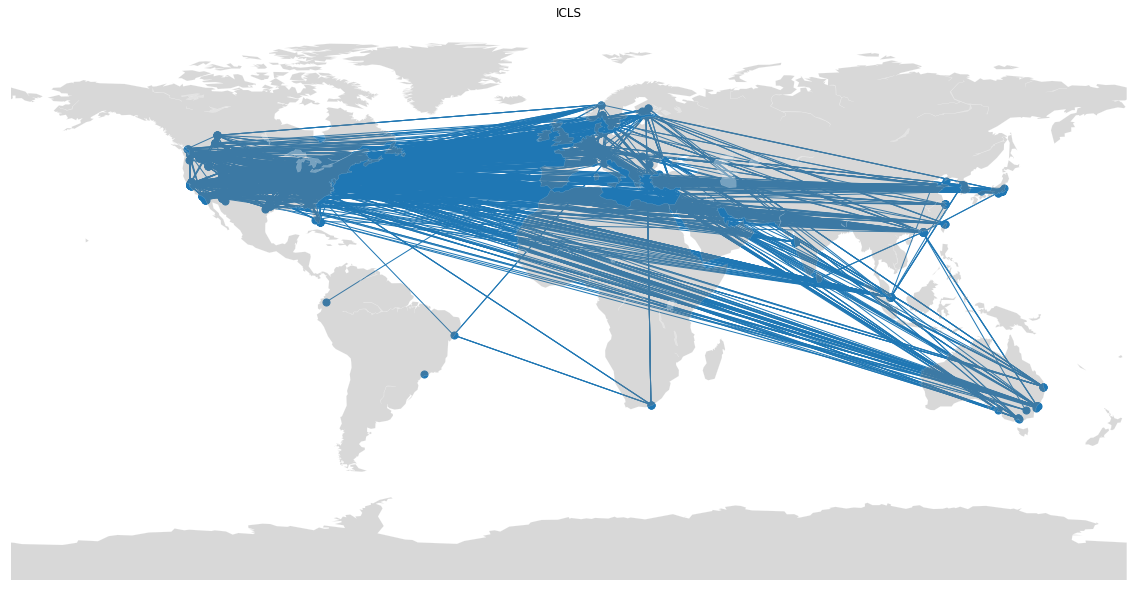

Attribute Assortativity coef: Country:  0.4271026311806175
Attribute Assortativity coef: Uni:  0.32151016774010155


/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


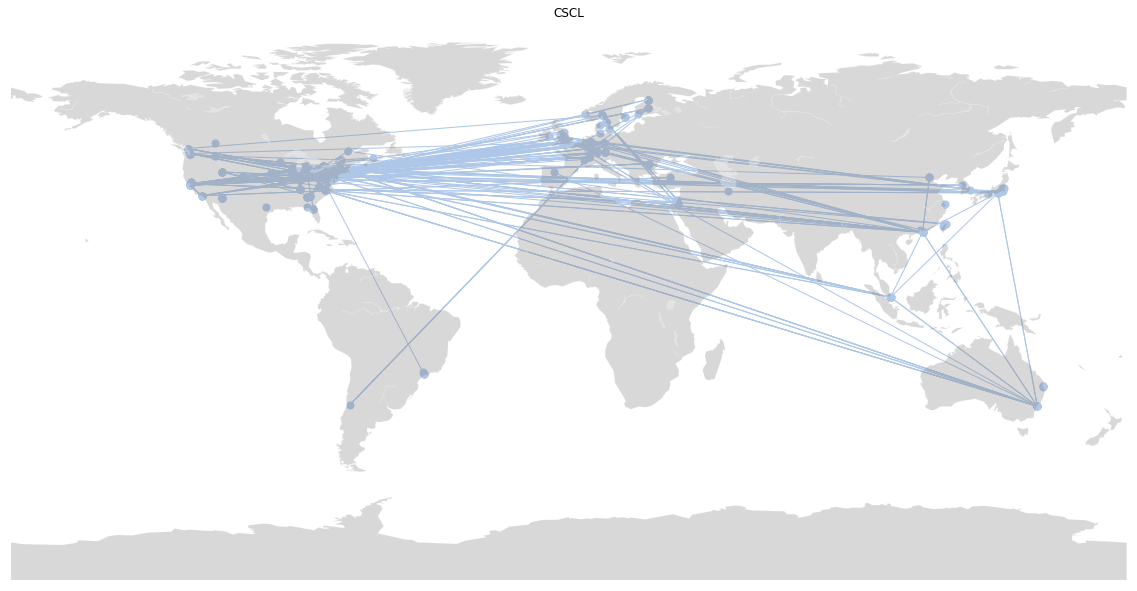

Attribute Assortativity coef: Country:  0.46834025119112455
Attribute Assortativity coef: Uni:  0.3920888192357482


In [146]:
for i, title in enumerate(['ICLS', 'CSCL']):
    plt.figure(figsize=(20, 20))
    plt.title(title)
    m=Basemap()
    m.drawmapboundary(linewidth=0)
    m.fillcontinents(color='grey', alpha=0.3)
    m.drawcoastlines(linewidth=0.1, color="white")
    data = nodes[nodes.issued % 2 == i].copy()
    cluster = nodes[nodes.issued % 2 == i].index.tolist()
    m.scatter(data['Lon'], data['Lat'], s= 50, c= palette.as_hex()[i], alpha=1)

    sub_network = graph.subgraph(cluster)
    embedding = nodes.iloc[cluster].apply(lambda x: [x.Lon, x.Lat], axis=1)
    nx.draw_networkx_edges(sub_network,  pos = embedding, 
                           edge_color=palette.as_hex()[i], width = 1)
    plt.show()
    print('Attribute Assortativity coef: Country: ', nx.attribute_assortativity_coefficient(sub_network, 'country'))
    print('Attribute Assortativity coef: Uni: ', nx.attribute_assortativity_coefficient(sub_network, 'uni'))


Again, combining the years we see that CSCL collaboration is more likely to be within a country/university than in ICLS.